In [1]:
# Imports
import sys
import os

# Add the upstream directory to sys.path
upstream_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if upstream_dir not in sys.path:
    sys.path.insert(0, upstream_dir)

# Now you can import the module
from opentrons_api import ot2_api
from microtissue_manipulator import core, utils, camera
import numpy as np 
import cv2
import time
import json
import keyboard
# from pynput import keyboard
import paths
import matplotlib.pyplot as plt
import requests
import datetime
import threading
import queue
import string
import pandas as pd
import multiprocessing as mp
from dataclasses import dataclass, fields, asdict, MISSING
from typing import get_type_hints, get_origin, get_args, Tuple, List, Dict, Any, Union
from ultralytics import YOLO
from enum import Enum
# from typeguard import typechecked
# from typeguard import install_import_hook
# install_import_hook('__main__')

In [2]:
cam_manager = camera.CameraManagerWindows()
print("Connected cameras:")
print(cam_manager.list_devices())

under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (4000,3000), focus = 940)
over_cam = camera.open_capture('overview_cam_2', cam_manager=cam_manager)
frame_ops = camera.frameOperations(*over_cam.shape[0:-1])

calibration_profile = 'checkerboard'
frame_ops.load_camera_intrinsics(config_profile=calibration_profile, use_new_cam_mtx=True)

time.sleep(3)
ret, _ = under_cam.read()
if ret:
    print("Under camera is working correctly.")
else:
    print("Under camera is not working.")

ret, _ = over_cam.read()
if ret:
    print("Over camera is working correctly.")
else:
    print("Over camera is not working.")

Connected cameras:
['Arducam B0478 (USB3 48MP)', 'HD USB CAMERA']
Under camera is working correctly.
Over camera is working correctly.


In [3]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (4000,3000), focus = 940)

In [5]:
_, frame = over_cam.read()
# over_cam.release()

In [6]:
frame.shape

(1944, 2592, 3)

In [ ]:
# Turn on camera
# calibration_profile = 'checkerboard'
# cap = core.Camera(1, config_profile=calibration_profile, use_new_cam_mtx=True)

In [5]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (4000,3000), focus = 900)

In [9]:
over_cam = camera.open_capture('overview_cam_2', cam_manager=cam_manager)
frame= over_cam.read()
print(frame[1].shape)



(1944, 2592, 3)


# Video test

In [ ]:
over_cam = camera.open_capture('overview_cam', cam_manager=cam_manager)


In [21]:
under_cam.release()

In [22]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (4000,3000), focus = 900)

In [11]:
calibration_data = utils.load_calibration_config(calibration_profile)
offset = np.array(calibration_data['offset'])

In [33]:
openapi.move_to_well(openapi.labware_dct['5'], 'B2', well_location='top', offset=(-offset[0]-1.5, -offset[1]+2, 15))

<Response [201]>

In [249]:
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

# manual_movement = utils.ManualRobotMovement(openapi)
capture = cv2.VideoCapture(0)  # Change the index if necessary
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 3264)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 2448)
while True:
    ret, frame = capture.read()
    # frame = frame_ops.undistort_frame(frame)

    cv2.imshow("video", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('s'):
        save_dir = "../outputs/images"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"frame_{timestamp}.png"
        filepath = os.path.join(save_dir, filename)
        cv2.imwrite(filepath, frame)
        print(f"Frame saved as {filepath}")

capture.release()
# keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

Frame saved as ../outputs/images\frame_20250813_151736.png


In [245]:
capture.release()

In [9]:
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

# manual_movement = utils.ManualRobotMovement(openapi)
capture = under_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        ret, frame = capture.read()
        # frame = frame_ops.undistort_frame(frame)

        cv2.imshow("video", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            save_dir = "../outputs/images"
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"frame_{timestamp}.png"
            filepath = os.path.join(save_dir, filename)
            cv2.imwrite(filepath, frame)
            print(f"Frame saved as {filepath}")

# capture.release()
keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

Streaming video. Press 'q' to quit.


In [17]:
under_cam.release()

In [ ]:
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)
# Run inference
frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(source=frame, save=False, imgsz=640,conf=0.1)

In [ ]:
cap = cv2.VideoCapture(0)  # 0 is the default camera
if not cap.isOpened():
    print("Error: Could not open video capture.")
else:
    print("Video capture opened successfully.")
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 4000)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 6000)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'YUY2'))

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

def set_focus(val):
    cap.set(cv2.CAP_PROP_FOCUS, val)
set_focus(900)


circle_center = (0, 0)

def draw_circle(event, x, y, flags, param):
    global circle_center
    if event == cv2.EVENT_LBUTTONDOWN:
        circle_center = (x, y)
        print(f"Circle center set to: {circle_center}")

cv2.setMouseCallback('video', draw_circle)
manual_movement = utils.ManualRobotMovement(openapi)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if circle_center != (0, 0):
        cv2.circle(frame, circle_center, 475, (0, 255, 0), 2)
    cv2.imshow('video', frame)
    k = cv2.waitKey(1) & 0xFF

    if k == ord('s'):
        print("frame saved")
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # filename = f'../outputs/images/underneath_dataset/saved_frame_{timestamp}.png'
        filename = f'../outputs/images/underneath_cuboids/saved_frame_{timestamp}.png'
        cv2.imwrite(filename, frame)

    if k == ord('q'):
        break

# When everything done, release the capture
cap.release()
keyboard.unhook_all()
cv2.destroyAllWindows()

Video capture opened successfully.


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Exception in thread Thread-4 (process):
Traceback (most recent call last):
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\site-packages\keyboard\_generic.py", line 58, in process
    if self.pre_process_event(event):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\site-packages\keyboard\__init__.py", line 218, in pre_process_event
    callback(event)
  File "c:\Users\ivand\miniconda3\envs\lab\Lib\site-packages\keyboard\__init__.py", line 649, in <lambda>
    handler = lambda e: (event_type == KEY_DOWN and e.event_type == KEY_UP and e.scan_code in _logically_pressed_keys) or (event_

In [ ]:
window = cap.get_window()

robot_coords = []
camera_coords = []

while True:
    frame = cap.get_frame(undist=True)
    cv2.imshow(cap.window_name, frame)

    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        break

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(os.path.join(paths.BASE_DIR, 'outputs', 'images', 'segmentation_test', filename), frame)
        print(f"Frame saved as {filename}")
   
cv2.destroyAllWindows()

# Init

In [3]:
# Connect the robot to the computer and this notebook
openapi = ot2_api.OpentronsAPI()

In [4]:
# Set the offset if the platform is used
openapi.add_slot_offsets([5,8,9], (0,0,64.2))

In [5]:
# Use the light control to see if the robot is connected as a sanity check
openapi.toggle_lights()

<Response [200]>

In [6]:
# Always do once after robot was just turned on
openapi.home_robot()

Request status:
<Response [200]>
{
  "message": "Homing robot."
}


<Response [200]>

In [5]:
# Use to restore labware and general run information after the notebook crashes
r = openapi.get_run_info()

Total number of runs: 20
Current run ID: 05f1dfc6-b384-48c4-9c1a-1d2794c92973
Current run status: idle


In [7]:
# Do after first launch
openapi.create_run()

Request status:
<Response [201]>
{
  "data": {
    "id": "05f1dfc6-b384-48c4-9c1a-1d2794c92973",
    "ok": true,
    "createdAt": "2025-06-01T16:48:27.155221Z",
    "status": "idle",
    "current": true,
    "actions": [],
    "errors": [],
    "hasEverEnteredErrorRecovery": false,
    "pipettes": [],
    "modules": [],
    "labware": [],
    "liquids": [],
    "liquidClasses": [],
    "labwareOffsets": [],
    "runTimeParameters": [],
    "outputFileIds": []
  }
}


<Response [201]>

In [8]:
# Let the robot know that it has the P300 pipette
openapi.load_pipette()

Request status:
<Response [201]>
{
  "data": {
    "id": "a03784f9-209b-48a7-b877-e4c62b838f3a",
    "createdAt": "2025-06-01T16:48:32.075171Z",
    "commandType": "loadPipette",
    "key": "a03784f9-209b-48a7-b877-e4c62b838f3a",
    "status": "succeeded",
    "params": {
      "pipetteName": "p300_single_gen2",
      "mount": "left"
    },
    "result": {
      "pipetteId": "7f82abb9-7cd1-4323-a63f-f71d09e22cb7"
    },
    "startedAt": "2025-06-01T16:48:32.078404Z",
    "completedAt": "2025-06-01T16:48:33.959233Z",
    "intent": "setup",
    "notes": []
  }
}


<Response [201]>

In [ ]:
openapi.control_run("stop")

In [8]:
openapi.move_relative('z', 20)

<Response [201]>

In [31]:
openapi.drop_tip_in_place()

<Response [201]>

In [6]:
openapi.move_labware(openapi.labware_dct['5'], 'offDeck')

<Response [201]>

# Under cam auto calibration

In [ ]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 940)

### Robot coordinate system gauge

In [ ]:
def get_tip_coordinates(results):
    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            if model.names[cls] == 'tip':
                tip_coords = ((int(box.xyxy[0][0]) + int(box.xyxy[0][2])) // 2, 
                                (int(box.xyxy[0][1]) + int(box.xyxy[0][3])) // 2)
                return tip_coords

movements = [None,('x', 3), ('y', 3)]

capture = under_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    for movement in movements:
        if movement is not None:
            axis, distance = movement
            openapi.move_relative(axis, distance)
            time.sleep(1)
        time.sleep(0.5)
        ret, frame = capture.read()
        if not ret:
            print("Error: Could not read frame from video stream.")
        else:   
            frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
            results = model.predict(
                    source=frame,  # Now pointing to a directory instead of a single file
                    conf=0.25,         # Confidence threshold
                    save=False,         # Save the annotated images
                    save_txt=False,    # Save YOLO-format prediction labels (optional)
                    show=False,         # Show images in pop-up windows (if GUI available)
                    imgsz=2000,
                    verbose = False        # Ensure inference matches your training resolution
                )
            tip_coords = get_tip_coordinates(results)
            print(f"Tip coordinates: {tip_coords}")
        if movement is not None:
            openapi.move_relative(axis, -distance)
            time.sleep(1)


  

### Find distance to tip

In [ ]:
manual_movement = utils.ManualRobotMovement(openapi)

In [ ]:
openapi.move_relative('x', 2)

In [ ]:
keyboard.unhook_all()  # Unhook all keyboard listeners

In [ ]:
under_cam.release()

In [ ]:
# under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 920)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)

manual_movement = utils.ManualRobotMovement(openapi)
capture = under_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        # if not capture.is_opened() or not capture.frame_ready.value:
        #     print("frame not ready or capture not opened, skipping frame.")
        #     continue
        ret, frame = capture.read()
        frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
        results = model.predict(
                source=frame,  # Now pointing to a directory instead of a single file
                conf=0.25,         # Confidence threshold
                save=False,         # Save the annotated images
                save_txt=False,    # Save YOLO-format prediction labels (optional)
                show=False,         # Show images in pop-up windows (if GUI available)
                imgsz=2016,
                verbose = False               # Ensure inference matches your training resolution
            )

        image = frame.copy()
        image_center = (image.shape[1] // 2, image.shape[0] // 2)
        data = []
        for r in results:
            for box in r.boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

        # Create a dataframe
        df = pd.DataFrame(data)

        # Calculate the distance of each "point" to the center of the frame
        # df['distance_to_center'] = ((df['center_x'] - image_center[0]) ** 2 + (df['center_y'] - image_center[1]) ** 2) ** 0.5

        # # Identify the closest "point" to the center of the frame
        # df['is_closest_to_center'] = (df['class'] == 'point') & (df['distance_to_center'] == df.loc[df['class'] == 'point', 'distance_to_center'].min()) & (df['distance_to_center'] < 100)

        # if df['is_closest_to_center'].any():
        #     distances_from_closest = np.sqrt(
        #         (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])**2 +
        #         (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'point', 'center_y'])**2
        #     )
        #     distances_from_closest = distances_from_closest[distances_from_closest > 0]
        #     linear_distance_ratio = 20.25 / np.mean(distances_from_closest)
        #      # Calculate the distance from the center-most "point" class to the "tip" class
        #     center_point_coords = df.loc[df['is_closest_to_center'], ['center_x', 'center_y']].values[0]
        #     # tip_coords = df.loc[df['class'] == 'tip', ['center_x', 'center_y']].values[0]

        #     # x_dist_to_tip = center_point_coords[0] - tip_coords[0]
        #     # y_dist_to_tip = center_point_coords[1] - tip_coords[1]
        #     # print(x_dist_to_tip, y_dist_to_tip)

        #     # y_dist_to_tip_mm = x_dist_to_tip * linear_distance_ratio
        #     # x_dist_to_tip_mm = y_dist_to_tip * linear_distance_ratio
        #     # print(f"x_dist_to_tip_mm: {x_dist_to_tip_mm}, y_dist_to_tip_mm: {y_dist_to_tip_mm}")

        #     # Draw center point coordinates
        #     cv2.circle(image, tuple(center_point_coords), 3, (0, 255, 0), -1)  # Green circle
        #     cv2.putText(image, f"Center {tuple(center_point_coords)}", tuple(center_point_coords), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Draw tip coordinates
        # cv2.circle(image, tuple(tip_coords), 3, (0, 0, 255), -1)  # Red circle
        # cv2.putText(image, f"Tip {tuple(tip_coords)}", tuple(tip_coords), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow("video", image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
 
# capture.release()
keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

In [ ]:

output_frame = frame.copy()
for idx, row in df.iterrows():
    center = (int(row['center_x']), int(row['center_y']))
    label = f"{row['class']}"
    cv2.circle(output_frame, center, 5, (0, 255, 0), -1)
    cv2.putText(output_frame, label, (center[0] + 10, center[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    conf_text = f"{row['confidence']:.2f}"
    cv2.putText(output_frame, conf_text, (center[0] + 10, center[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

cv2.imshow("video", output_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
cv2.imwrite("output_frame.png", output_frame)
print("Output frame saved as output_frame.png")

In [ ]:
openapi.move_relative('x', x_dist_to_tip_mm)
openapi.move_relative('y', y_dist_to_tip_mm)

# Requests experiments

### Add labware offsets to a run

In [ ]:
r[-1]

In [ ]:
# payload = {
#   "data": {
#     "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#     "locationSequence": [
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "3"
#       }
#     ],
#     "vector": {
#       "x": 0,
#       "y": 0,
#       "z": 65
#     }
#   }
# }

data = {
    "data": {
                "definitionUri": "opentrons/corning_24_wellplate_3.4ml_flat/1",
                "location": {
                    "slotName": "3",
                    },
                "vector": {
                    "x": 0,
                    "y": 0,
                    "z": 65
                    }
}
}
payload = json.dumps(data)

In [ ]:
r = requests.post(url = openapi.BASE_URL+'/runs/'+openapi.run_id +'/labware_offsets', headers = openapi.HEADERS, data = payload)

In [ ]:
json.loads(r.text)

### Other

In [34]:
y_05 = [14,14,14,16,15,16,16,17,15,17]
y_1 = [29,30,30,31,33,33,33,33,32,32]
y_15 = [46,46,47,49,49,50,49,48,50,49]
y_2 = [62,62,63,65,63,64,66,66,66,62]

x = [0.5, 1,1.5, 2]

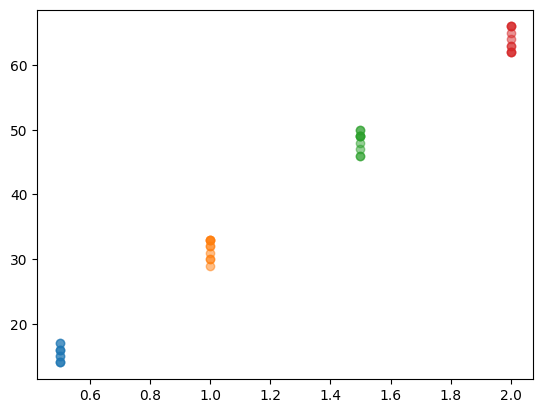

In [42]:
plt.figure()
plt.scatter(np.ones(10)*x[0], y_05, label='0.5 mm', marker='o', alpha=0.5)
plt.scatter(np.ones(10)*x[1], y_1, label='1 mm', marker='o', alpha=0.5)  
plt.scatter(np.ones(10)*x[2], y_15, label='1.5 mm', marker='o', alpha=0.5)
plt.scatter(np.ones(10)*x[3], y_2, label='2 mm', marker='o', alpha=0.5)

Conversion factor: 32.44 pixels per mm


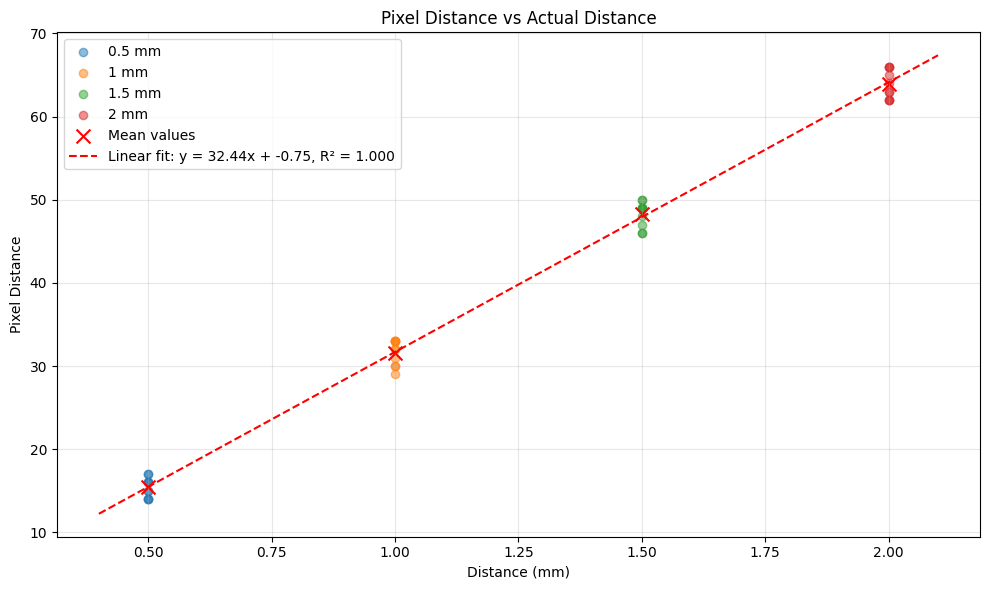

In [43]:
import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt

# Calculate the mean values for each group
y_05_mean = np.mean(y_05)
y_1_mean = np.mean(y_1)
y_15_mean = np.mean(y_15)
y_2_mean = np.mean(y_2)

# Create arrays for regression
x_data = np.array(x)
y_means = np.array([y_05_mean, y_1_mean, y_15_mean, y_2_mean])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_data, y_means)

# Create a line using the slope and intercept
x_line = np.linspace(0.4, 2.1, 100)
y_line = slope * x_line + intercept

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(np.ones(10)*x[0], y_05, label='0.5 mm', marker='o', alpha=0.5)
plt.scatter(np.ones(10)*x[1], y_1, label='1 mm', marker='o', alpha=0.5)  
plt.scatter(np.ones(10)*x[2], y_15, label='1.5 mm', marker='o', alpha=0.5)
plt.scatter(np.ones(10)*x[3], y_2, label='2 mm', marker='o', alpha=0.5)

# Plot the means for each group
plt.scatter(x_data, y_means, color='red', marker='x', s=100, label='Mean values')

# Plot the regression line
plt.plot(x_line, y_line, 'r--', label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.3f}')

plt.title('Pixel Distance vs Actual Distance')
plt.xlabel('Distance (mm)')
plt.ylabel('Pixel Distance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Calculate and print the conversion factor (pixels per mm)
conversion_factor = slope
print(f"Conversion factor: {conversion_factor:.2f} pixels per mm")

In [ ]:
# data = {
#     "data": {
#         "labwareOffsets": [
#             {
#                 "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#                 "location": {
#                     "slotName": "6",
#                     },
#                 "vector": {
#                     "x": 0,
#                     "y": 0,
#                     "z": 65
#                     }
#             }
#     ]
#     }
# }

# data = {
#   "data": {
#     "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#     "locationSequence": [
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "3"
#       },
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "6"
#       }
#     ],
#     "vector": {
#       "x": 0,
#       "y": 0,
#       "z": 65
#     }
#   }
# }
# payload = json.dumps(data)

In [ ]:
json.dumps(data)

In [ ]:
r = requests.post(url = openapi.BASE_URL+'/labwareOffsets', headers = openapi.HEADERS, data = payload)

In [ ]:
r = requests.get(url = openapi.BASE_URL+'/labwareOffsets', headers = openapi.HEADERS)

In [ ]:
r = openapi.post("runs", openapi.HEADERS, data = json.dumps(data))

In [ ]:
json.loads(r.text)

In [ ]:
command_dict = {
            "data": {
                "commandType": "verifyTipPresence",
                "params": {
                    "pipetteId": openapi.pipette_id,
                    "expectedState": "present",
                },
                "intent": "setup"
            }
        }

command_payload = json.dumps(command_dict)
r = openapi.post("commands", headers = openapi.HEADERS,
                params={"waitUntilComplete": True}, data = command_payload)

# Labware declaration

### Opentrons 300 ul

In [8]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "opentrons_96_tiprack_300ul"
#Load the tip rack. Slot = 1 by default.
r = openapi.load_labware(TIP_RACK, 11)

Labware ID:
6a581d7b-b2ef-466e-a273-936e3481d03b



In [9]:
r = openapi.pick_up_tip(openapi.labware_dct['11'], "C1")

### VWR 200ul Wide bore

In [ ]:
custom_labware_path = os.path.join(paths.BASE_DIR,'protocols','vwr_96_tiprack_200ul.json')
with open(custom_labware_path, 'r') as json_file:
    custom_labware = json.load(json_file)

command_dict = {
            "data": custom_labware
        }

command_payload = json.dumps(command_dict)

url = openapi.get_url('runs')+ f'/{openapi.run_id}/'+ 'labware_definitions'
r = requests.post(url = url, headers = openapi.HEADERS, params = {"waitUntilComplete": True}, data = command_payload)

In [ ]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "wide_bore_200ul"
#Load the tip rack. Slot = 1 by default.
openapi.load_labware(TIP_RACK, 10, namespace='custom_beta',verbose=True)

In [ ]:
r = openapi.pick_up_tip(openapi.labware_dct['10'], "A1")

In [ ]:
openapi.drop_tip_in_place()

### VWR 200 ul XL

In [32]:
custom_labware_path = os.path.join(paths.BASE_DIR,'protocols','vwr_96_tiprack_200ul_xl.json')
with open(custom_labware_path, 'r') as json_file:
    custom_labware = json.load(json_file)

command_dict = {
            "data": custom_labware
        }

command_payload = json.dumps(command_dict)

url = openapi.get_url('runs')+ f'/{openapi.run_id}/'+ 'labware_definitions'
r = requests.post(url = url, headers = openapi.HEADERS, params = {"waitUntilComplete": True}, data = command_payload)

In [33]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "vwr_96_tiprack_200ul_xl"
#Load the tip rack. Slot = 1 by default.
openapi.load_labware(TIP_RACK, 10, namespace='custom_beta',verbose=True)

AssertionError: Error loading labware...

In [34]:
r = openapi.pick_up_tip(openapi.labware_dct['10'], "A9")

### Reservoir and well plates

In [35]:
RESERVOIR = "corning_6_wellplate_16.8ml_flat"
r = openapi.load_labware(RESERVOIR, 4, namespace='opentrons',verbose=True)

Labware ID:
559c18a2-791a-4f46-94d6-07713be9d3a2



In [6]:
WELL_PLATE = "corning_96_wellplate_360ul_flat"
# WELL_PLATE = "corning_24_wellplate_3.4ml_flat"
# WELL_PLATE = "corning_384_wellplate_112ul_flat"
r = openapi.load_labware(WELL_PLATE, 5, namespace='opentrons',verbose=True)

Offset (0, 0, 64.2) added to run for corning_96_wellplate_360ul_flat in slot 5.
Labware URI:
opentrons/corning_96_wellplate_360ul_flat/1

Check offset before using ...
Labware ID:
b0897cf1-6b5c-4d15-aa44-5e9abda557e1



In [81]:
openapi.drop_tip_in_place()

<Response [201]>

In [18]:
openapi.blow_out_in_place()

<Response [201]>

In [ ]:
openapi.drop_tip(openapi.labware_dct['10'], "B11")

In [19]:
openapi.aspirate(openapi.labware_dct['4'], "A1", well_location='center', volume = 70, flow_rate = 200)

<Response [201]>

In [51]:
openapi.move_labware(openapi.labware_dct['1'], new_location='offDeck')

<Response [201]>

In [33]:
openapi.move_relative('y', -20)

<Response [201]>

In [ ]:
flow_rate = 200
volume = 100

openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

In [20]:
flow_rate = 200
volume = 70
openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

<Response [201]>

# Filling a well plate

### Taking off solution with video

In [19]:
x_offset_r = -0.5
y_offset_r = 0.5
z_offset = 1
openapi.move_to_well(openapi.labware_dct['5'], "H1", well_location='top', offset=(x_offset_r,y_offset_r,z_offset))

<Response [201]>

In [20]:
manual_movement = utils.ManualRobotMovement(openapi)

In [21]:
keyboard.unhook_all()

In [22]:
openapi.get_position()

{'x': 146.38, 'y': 102.24, 'z': 67.72000000000003}


({'x': 146.38, 'y': 102.24, 'z': 67.72000000000003}, <Response [201]>)

In [23]:
openapi.move_relative('z', 20)

<Response [201]>

In [24]:
plate_type = 96
dest = core.Destination(plate_type)
well_df = core.create_well_plan(plate_type)
well_df.loc['H',2:11] = 1
# well_df.loc['G',:6] = 1
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
take_off_solution_routine = core.Routine(dest, well_plan)
well_df

,1,2,3,4,5,6,7,8,9,10,11,12
A,0,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0
H,0,1,1,1,1,1,1,1,1,1,1,0


In [34]:
openapi.move_to_well(openapi.labware_dct['5'], 'A1', well_location='top', offset=(-offset[0], -offset[1], 30))

<Response [201]>

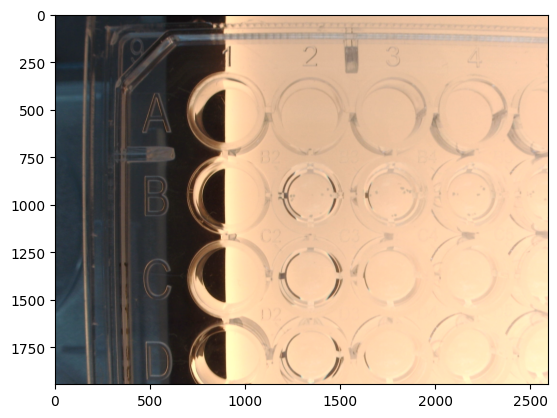

In [29]:
_, frame = over_cam.read()
plt.imshow(frame)

In [ ]:
x_offset = -0.5
y_offset = 0.5
z_offset = 1

aspirate_z_offset = 1.5
well_plate_bottom = 67.72 #73.22
takeoff_volume = 100
flow_rate = 10
well_plate_slot = '5'
reservoir_slot = '4'

calibration_data = utils.load_calibration_config(calibration_profile)
offset = np.array(calibration_data['offset'])

openapi.retract_axis('leftZ')
openapi.blow_out(openapi.labware_dct[reservoir_slot], "B2", well_location='top', flow_rate = 20)
openapi.aspirate(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
openapi.retract_axis('leftZ')

while not take_off_solution_routine.is_done():
    well = take_off_solution_routine.get_next_well()

    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(-offset[0], -offset[1], 30))
    time.sleep(1)
    _, before = over_cam.read()

    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset))
    robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
    openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + aspirate_z_offset), min_z_height=well_plate_bottom, verbose=False, force_direct=True)

    r = openapi.aspirate_in_place(volume = takeoff_volume, flow_rate = flow_rate)
    time.sleep(0.1)

    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset), force_direct=True)
    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(-offset[0], -offset[1], 30))
    time.sleep(1)
    _, after = over_cam.read()

    filename = f'../outputs/images/taking_solution_off_experiment_2/before_{well}_{aspirate_z_offset}mm_{flow_rate}uls.png'
    cv2.imwrite(filename, before)
    filename = f'../outputs/images/taking_solution_off_experiment_2/after_{well}_{aspirate_z_offset}mm_{flow_rate}uls.png'
    cv2.imwrite(filename, after)

    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset))
    robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
    openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + aspirate_z_offset), min_z_height=well_plate_bottom, verbose=False, force_direct=True)
    r = openapi.dispense_in_place(volume = takeoff_volume, flow_rate = 50)
    openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset), force_direct=True)

    responce_dict = json.loads(r.text)['data']
    if responce_dict['status'] == 'failed':
        if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
            print('Dumping fluid')
            openapi.blow_out(openapi.labware_dct[reservoir_slot], "B2", well_location='top', flow_rate = 20)
            # time.sleep(5)
            openapi.aspirate(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
            openapi.dispense(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
    else:
        take_off_solution_routine.update_well(success=True)
        take_off_solution_routine.get_next_well()

      
openapi.retract_axis('leftZ')
openapi.blow_out(openapi.labware_dct[reservoir_slot], "B2", well_location='top', flow_rate = 50)
openapi.aspirate(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct[reservoir_slot], "B1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
openapi.retract_axis('leftZ')

<Response [201]>

### Taking off solution

In [83]:
openapi.toggle_lights()

<Response [200]>

In [63]:
# Determine bottom of well plate
x_offset_r = -0.5
y_offset_r = 0
z_offset = -10
openapi.move_to_well(openapi.labware_dct['5'], "H1", well_location='top', offset=(x_offset_r,y_offset_r,z_offset))

<Response [201]>

In [90]:
keyboard.unhook_all()  # Unhook all keyboard listeners

In [89]:
openapi.get_position()

{'x': 9.819999999999999, 'y': 45.49, 'z': 14.219999999999988}


({'x': 9.819999999999999, 'y': 45.49, 'z': 14.219999999999988},
 <Response [201]>)

In [91]:
openapi.retract_axis('leftZ')

<Response [201]>

In [95]:
openapi.move_to_coordinates((15.13, 10.990000000000002, 3.12), verbose=False)

<Response [201]>

In [86]:
height = 0.75
rad = 3.325
x_offset = np.sqrt(rad**2 - (rad - height)**2)
x_offset

2.103568396796263

In [ ]:
#08/21/2025 - U-bottom 96 well plate.
#H1 top - 14.12
#H12 top - 13.92
#A12 top - 14.12
#A1 top - 14.02

# 14.02,       
# 13.92,        
# 13.9,
# 13.92

#08/13/2025 - U-bottom 96 well plate.
#H1 top - 14.02
#H12 top - 13.82
#A1 top - 13.82
#A12 top - 13.82

#08/14/2025 - U-bottom 96 well plate.
#H1 top - 13.82
#H12 top - 13.72
#A12 top - 13.72
#A1 top - 13.72

#08/12/2025 - U-bottom 96 well plate.
#H1 top - 13.92 H1 bottom - 3.12 : height of well = ~10.8

In [ ]:
#08/20/2025 - Flat bottom 96 well-plate.
#H1 top - 14.02
#H12 top - 13.92
#A12 top - 13.82
#A1 top - 14.02

#H1 top - 14.22
#H12 top - 14.02
#A12 top - 14.12
#A1 top - 14.22

#H1 top - 14.32
#H12 top - 14.12
#A12 top - 14.12
#A1 top - 14.22

#08/15/2025 - Flat bottom 96 well-plate.
#H1 top - 14.12
#H12 top - 14.02
#A1 top - 14.12
#A12 top - 14.12

#H1 top - 14.22
#H12 top - 14.12
#A12 top - 14.22
#A1 top - 14.22

#14.27
#14.12
#14.32
#14.32

#14.22
#14.12
#14.22
#14.22

#14.22
#14.12
#14.12
#14.22
#--------------------------------------------

#08/11/2025
#H1 top - 14.42
#H12 top - 14.22
#A12 top - 14.12
#A1 top - 14.32

#08/06/2025
#H1 top - 14.12
#H12 top - 13.92
#A1 top - 14.12
#A12 top - 13.92

#Previous values:
#H1 top - 13.72
#H12 top - 13.52
#A1 top - 13.72
#A12 top  - 13.52

In [ ]:
#  384-U-bottom
14.52 - 12.5

2.0199999999999996

In [ ]:
# 96 flat-bottom
14.02 - 10.5

3.5199999999999996

In [ ]:
# 96 U-bottom
13.92 - 10.8

3.119999999999999

In [26]:
# 384 flat-bottom
14.22 - 11.5

2.7200000000000006

In [58]:
openapi.move_relative('z', 20)

<Response [201]>

In [ ]:
#67.62 #H1
#67.72 #A1
#67.32 #H12
#67.52 #A12

In [34]:
openapi.drop_tip_in_place()

<Response [201]>

In [63]:
openapi.dispense_in_place(volume = 200, flow_rate = 100)

<Response [201]>

In [35]:
openapi.pick_up_tip(openapi.labware_dct['11'], "C2")

<Response [201]>

In [14]:
plate_type = 96
dest = core.Destination(plate_type)
well_df = core.create_well_plan(plate_type)
well_df.loc['G',2:11] = 1
# well_df.loc['G',:6] = 1
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
take_off_solution_routine = core.Routine(dest, well_plan)
well_df

,1,2,3,4,5,6,7,8,9,10,11,12
A,0,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,0,0
G,0,1,1,1,1,1,1,1,1,1,1,0
H,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
# Determine bottom of well plate
x_offset_r = -0.5
y_offset_r = 0.0
z_offset = 0
openapi.move_to_well(openapi.labware_dct['5'], "H2", well_location='top', offset=(x_offset_r,y_offset_r,z_offset))
well_plate_bottom = 70.42 - 10.5
robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + 0.5), min_z_height=well_plate_bottom, verbose=False, force_direct=True)
# time.sleep(5)
openapi.aspirate_in_place(volume = 100, flow_rate = 50)
time.sleep(1)
openapi.retract_axis('leftZ')

<Response [201]>

In [76]:
openapi.move_to_well(openapi.labware_dct['5'], "H1", well_location='top', offset=(x_offset_r,y_offset_r,z_offset))
well_plate_bottom = 70.42 - 10.5
robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + 0.5), min_z_height=well_plate_bottom, verbose=False, force_direct=True)
openapi.dispense_in_place(volume = 100, flow_rate = 50)
openapi.retract_axis('leftZ')

<Response [201]>

In [86]:
openapi.dispense_in_place(volume = 100, flow_rate = 50)

<Response [201]>

In [65]:
manual_movement = utils.ManualRobotMovement(openapi)

In [66]:
openapi.get_position()

{'x': 142.38, 'y': 101.74, 'z': 70.42}


({'x': 142.38, 'y': 101.74, 'z': 70.42}, <Response [201]>)

In [43]:
14.28 - 12.5

1.7799999999999994

In [68]:
openapi.retract_axis('leftZ')

<Response [201]>

In [67]:
keyboard.unhook_all()

In [50]:
x_offset = 0.1
y_offset = 0.5
z_offset = 1
aspirate_z_offsets = [3.0]
# aspirate_z_offsets = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

# rows = ['B','C', 'D', 'E', 'F', 'G']
rows = ['N']

# rows = ['D']
well_plate_bottom = 1.78#3.12#73.22
takeoff_volume = 100
flow_rate = 50
well_plate_slot = '1'
reservoir_slot = '4'

hor_offsets_dict = {0.5:1,
                    0.75:2,
                    1.0:2,
                    1.25:2.5,
                    1.5:2.5,
                    2.0:2.5,
                    2.5:2.5,
                    3.0:2.5,
                    3.5:2.5}

# intended_volume_to_leave = 20
# aspirate_z_offset = (intended_volume_to_leave + 0.75) / 32.44
for idx, aspirate_z_offset in enumerate(aspirate_z_offsets):

    plate_type = 96
    dest = core.Destination(plate_type)
    well_df = core.create_well_plan(plate_type)
    well_df.loc[rows[idx],2:11] = 1
    # well_df.loc['G',:6] = 1
    well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
    take_off_solution_routine = core.Routine(dest, well_plan)

    print(well_plan)
    print(aspirate_z_offset)
    print('-'*20)
    
    openapi.retract_axis('leftZ')
    openapi.blow_out(openapi.labware_dct[reservoir_slot], "A2", well_location='top', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
    openapi.retract_axis('leftZ')

    while not take_off_solution_routine.is_done():
        well = take_off_solution_routine.get_next_well()
        openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset))
        robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + aspirate_z_offset), min_z_height=well_plate_bottom, verbose=False, force_direct=True)
        # For U-bottom:
        # time.sleep(0.2)
        # openapi.move_relative('x', -hor_offsets_dict[aspirate_z_offset])


        r = openapi.aspirate_in_place(volume = takeoff_volume, flow_rate = flow_rate)
        # responce_dict = json.loads(r.text)['data']
        # if not responce_dict['status'] == 'failed':
        #     openapi.dispense_in_place(volume = 20, flow_rate = 300)
        # time.sleep(0.1)
        openapi.move_to_well(openapi.labware_dct[well_plate_slot], well, well_location='top', offset=(x_offset, y_offset, z_offset), force_direct=True)
        responce_dict = json.loads(r.text)['data']
        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
                print('Dumping fluid')
                openapi.blow_out(openapi.labware_dct[reservoir_slot], "A2", well_location='top', flow_rate = 200)
                # time.sleep(5)
                openapi.aspirate(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
                openapi.dispense(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
        else:
            take_off_solution_routine.update_well(success=True)
            take_off_solution_routine.get_next_well()

      
    openapi.retract_axis('leftZ')
    openapi.blow_out(openapi.labware_dct[reservoir_slot], "A2", well_location='top', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[reservoir_slot], "A1", well_location='top', offset = (0,0, z_offset), volume = 10, flow_rate = 200)
    openapi.retract_axis('leftZ')

{'N2': 1.0, 'N3': 1.0, 'N4': 1.0, 'N5': 1.0, 'N6': 1.0, 'N7': 1.0, 'N8': 1.0, 'N9': 1.0, 'N10': 1.0, 'N11': 1.0}
3.0
--------------------
Dumping fluid
Dumping fluid
Dumping fluid


In [27]:
openapi.aspirate(openapi.labware_dct[reservoir_slot], "A1", well_location='bottom', offset = (0,0, 0), volume = 100, flow_rate = 200)
openapi.dispense(openapi.labware_dct[reservoir_slot], "A1", well_location='bottom', offset = (0,0, 0), volume = 100, flow_rate = 200)

<Response [201]>

In [28]:
openapi.retract_axis('leftZ')

<Response [201]>

In [32]:
openapi.dispense_in_place(volume = 250, flow_rate = 200)

<Response [201]>

### Rinse pipette

In [ ]:
rinse_location = 3
well_to_wash = "A1"
well_to_rinse = "B1"
for i in range(3):
    openapi.aspirate(openapi.labware_dct[str(rinse_location)], well_to_wash, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[str(rinse_location)], well_to_wash, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)

for i in range(3):
    openapi.aspirate(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)

openapi.move_to_well(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='top', offset=(0,0,10))

### Other stuff

In [ ]:
openapi.retract_axis('leftZ')
openapi.move_to_well(openapi.labware_dct['1'], 'H2', well_location='top', offset=(0.3, -0.8, 0))
robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + 2), min_z_height=well_plate_bottom, verbose=False, force_direct=True)
openapi.aspirate_in_place(volume = 100, flow_rate = 100)
openapi.retract_axis('leftZ')


<Response [201]>

In [80]:
openapi.retract_axis('leftZ')

<Response [201]>

In [55]:
well_plate_bottom

3.52

In [68]:
openapi.move_to_coordinates((robot_x, robot_y, well_plate_bottom + 1.25), min_z_height=well_plate_bottom, verbose=False, force_direct=True)

<Response [201]>

In [71]:
openapi.aspirate_in_place(volume = 50, flow_rate = 100)    

<Response [201]>

In [17]:
openapi.move_to_well(openapi.labware_dct['1'], "H1", well_location='top', offset=(0.7,-0.5,0))

<Response [201]>

In [70]:
manual_movement = utils.ManualRobotMovement(openapi)

In [75]:
keyboard.unhook_all()  # Unhook all keyboard listeners

In [74]:
openapi.get_position()

{'x': 233.8052719363171, 'y': 222.1970684184191, 'z': 64.69}


({'x': 233.8052719363171, 'y': 222.1970684184191, 'z': 64.69},
 <Response [201]>)

In [81]:
14.22 - 10.5

3.7200000000000006

In [ ]:
#Well plate bottom coordinates

#H1 - 67.72
#H12 - 67.32
#A12 - 67.42
#A1 - 67.42

In [ ]:
#lu 'x': 146.88, 'y': 164.74, 'z': 63.920000000000016
#ru 'x': 245.88000000000002, 'y': 164.74, 'z': 63.84000000000003
#rl 'x': 245.88000000000002, 'y': 101.74, 'z': 63.920000000000016
#ll 'x': 146.88, 'y': 101.74, 'z': 64.02000000000001

In [59]:
openapi.move_relative('z', 20)

<Response [201]>

In [138]:
openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 200)

<Response [201]>

In [72]:
openapi.blow_out(openapi.labware_dct['4'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['4'], "A1", volume = 50, flow_rate = 200, well_location='center')
openapi.dispense(openapi.labware_dct['4'], "A1", volume = 50, flow_rate = 200, well_location='center')
openapi.retract_axis('leftZ')

<Response [201]>

In [33]:
openapi.retract_axis('leftZ')

columns = list(range(2,12))
# columns = [1,12]
# rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
# rows = ['B', 'C','D','E','F','G']
rows = ['I', 'J', 'K', 'L', 'M', 'N']
# rows = ['B']
x_offset = 0.7
y_offset = -0.7

row_idx = 0
column_idx = 0

source_slot = '4'
dest_slot = '1'
source_well = 'A1'


while row_idx < len(rows):
    row = rows[row_idx]
    while column_idx < len(columns):
        column = columns[column_idx]
        r = openapi.dispense(openapi.labware_dct[dest_slot], f"{row}{column}", well_location = 'bottom', offset = (x_offset, y_offset, 0.5), volume = 100, flow_rate = 200)
        openapi.move_relative('z', 20)
        responce_dict = json.loads(r.text)['data']
        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidDispenseVolumeError':
                print('Refilling pipette')
                openapi.aspirate(openapi.labware_dct[source_slot], source_well, well_location ='bottom',offset = (0,0,0.5), volume = 300, flow_rate = 200)
        else:
            column_idx += 1
    column_idx = 0
    row_idx += 1

openapi.blow_out(openapi.labware_dct[source_slot], source_well, well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct[source_slot], "A2", volume = 50, flow_rate = 200)
openapi.dispense(openapi.labware_dct[source_slot], "A2", volume = 50, flow_rate = 200)
openapi.retract_axis('leftZ')

Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette


<Response [201]>

In [41]:
openapi.drop_tip_in_place()

<Response [201]>

In [88]:
openapi.blow_out(openapi.labware_dct['4'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['4'], "A2", volume = 50, flow_rate = 200)
openapi.dispense(openapi.labware_dct['4'], "A2", volume = 50, flow_rate = 200)

<Response [201]>

In [128]:
openapi.aspirate(openapi.labware_dct['4'], "A1", well_location='bottom', volume = 10, flow_rate = 200)

<Response [201]>

In [127]:
openapi.dispense(openapi.labware_dct['4'], "A1", volume = 10, flow_rate = 200)

<Response [201]>

In [ ]:
json.loads(r.text)['data']['error']['errorType']

# Robot <-> camera calibration

In [36]:
openapi.toggle_lights()

<Response [200]>

In [37]:
squaresX=7
squaresY=5 
squareLength=0.022
markerLength=0.011
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, params)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)
calibration_data = utils.load_calibration_config(calibration_profile)
manual_movement = utils.ManualRobotMovement(openapi)

calib_origin = calibration_data['calib_origin']
openapi.move_to_coordinates(calib_origin, min_z_height=1, verbose=False)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

robot_coords = []
new_calib_origin = None

while True:
 # Capture frame-by-frame
    ret, frame = over_cam.read()
    # frame = frame_ops.undistort_frame(frame)

    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 100), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Calculate the center of each quarter of the screen
    quarter_centers = [
        (center_screen_x // 2, center_screen_y // 2),
        (3 * center_screen_x // 2, center_screen_y // 2),
        (center_screen_x // 2, 3 * center_screen_y // 2),
        (3 * center_screen_x // 2, 3 * center_screen_y // 2)
    ]

    # Draw circles at the center of each quarter
    for qx, qy in quarter_centers:
        cv2.circle(frame, (qx, qy), 5, (0, 255, 255), -1)
        cv2.putText(frame, f"({qx}, {qy})", (qx + 10, qy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
    marker_corners, marker_ids, _ = detector.detectMarkers(frame)
    if marker_corners:
        for corner in marker_corners:
            corner = corner.reshape((4, 2))
            for point in corner:
                cv2.circle(frame, tuple(point.astype(int)), 5, (0, 255, 0), -1)

            center_x = int(np.mean(corner[:, 0]))
            center_y = int(np.mean(corner[:, 1]))
            cv2.circle(frame, (center_x, center_y), 5, (255, 0, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Calculate side lengths
    side_lengths = []
    if marker_corners:
        for corner in marker_corners[0]:
            for i in range(4):
                side_length = np.linalg.norm(corner[i] - corner[(i + 1) % 4])
                side_lengths.append(side_length)

    # Calculate the average side length
        average_side_length = np.mean(side_lengths)
        area = cv2.contourArea(marker_corners[0])
        one_d_ratio = 13.83 / average_side_length
        size_conversion_ratio = 13.83 ** 2 / area
        cv2.putText(frame, f"Area of marker: {area:.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("video", frame)

    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        x, y, z = openapi.get_position(verbose=False)[0].values()
        new_calib_origin = (x, y, z)
        break

# When everything done, release the capture
# cap.release_camera()
cv2.destroyAllWindows()

calibration_data = utils.load_calibration_config(calibration_profile)
calibration_data['size_conversion_ratio'] = size_conversion_ratio
calibration_data['one_d_ratio'] = one_d_ratio
if new_calib_origin:
    calibration_data['calib_origin'] = new_calib_origin
    print(f"New calibration origin set to: {new_calib_origin}")

utils.save_calibration_config(calibration_profile, calibration_data)

New calibration origin set to: (179.55999999999997, 160.78, 115.00000000000001)


In [38]:
calibration_data = utils.load_calibration_config(calibration_profile)
calib_origin = calibration_data['calib_origin']

spacing = 5  # Distance from the calib_point in mm

# Calculate the four coordinates
calibration_points = [
    (calib_origin[0] + spacing, calib_origin[1] + spacing),  # Right
    (calib_origin[0] + spacing, calib_origin[1] - spacing),  # Left
    (calib_origin[0] - spacing, calib_origin[1] - spacing),  # Up
    (calib_origin[0] - spacing, calib_origin[1] + spacing)   # Down
]

robot_coords = []
camera_coords = []


# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

for calib_pt in calibration_points:
    openapi.move_to_coordinates((*calib_pt, 100), min_z_height=1, verbose=False)
    cv2.waitKey(1000)
    # frame = cap.get_frame(undist=True)
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Calculate the center of each quarter of the screen
    quarter_centers = [
        (center_screen_x // 2, center_screen_y // 2),
        (3 * center_screen_x // 2, center_screen_y // 2),
        (center_screen_x // 2, 3 * center_screen_y // 2),
        (3 * center_screen_x // 2, 3 * center_screen_y // 2)
    ]

    # Draw circles at the center of each quarter
    for qx, qy in quarter_centers:
        cv2.circle(frame, (qx, qy), 5, (0, 255, 255), -1)
        cv2.putText(frame, f"({qx}, {qy})", (qx + 10, qy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    marker_corners, marker_ids, _ = detector.detectMarkers(frame)
    if marker_corners:
        for corner in marker_corners:
            corner = corner.reshape((4, 2))
            for point in corner:
                cv2.circle(frame, tuple(point.astype(int)), 5, (0, 255, 0), -1)

            center_x = int(np.mean(corner[:, 0]))
            center_y = int(np.mean(corner[:, 1]))
            cv2.circle(frame, (center_x, center_y), 5, (255, 0, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    cv2.waitKey(1)
    cv2.imshow("video", frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    robot_coords.append((x, y))
    camera_coords.append((center_x, center_y))

cv2.destroyAllWindows()

# Testing Z calibration

In [48]:
under_cam.release()

In [49]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 900)

In [50]:
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
squaresX=7
squaresY=5 
squareLength=0.022
markerLength=0.011
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, params)
# manual_movement = utils.ManualRobotMovement(openapi)
capture = under_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        ret, frame = capture.read()
        # frame = frame_ops.undistort_frame(frame)
        marker_corners, marker_ids, _ = detector.detectMarkers(frame)
        if marker_corners:
            for corner in marker_corners:
                corner = corner.reshape((4, 2))
                for point in corner:
                    cv2.circle(frame, tuple(point.astype(int)), 5, (0, 255, 0), -1)

                center_x = int(np.mean(corner[:, 0]))
                center_y = int(np.mean(corner[:, 1]))
                cv2.circle(frame, (center_x, center_y), 5, (255, 0, 0), -1)
                cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
        cv2.imshow("video", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            save_dir = "../outputs/images"
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"frame_{timestamp}.png"
            filepath = os.path.join(save_dir, filename)
            cv2.imwrite(filepath, frame)
            print(f"Frame saved as {filepath}")

# capture.release()
keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

Streaming video. Press 'q' to quit.


# Write transformation matrix

In [17]:
calibration_data = utils.load_calibration_config(calibration_profile)

camera_coords = utils.sort_coordinates(camera_coords)
robot_coords = utils.sort_coordinates(robot_coords, reverse_y=True)

robot_to_camera_coords = {tuple(robot_coord): tuple(camera_coord) for robot_coord, camera_coord in zip(robot_coords, camera_coords)}
tf_mtx = utils.compute_tf_mtx(robot_to_camera_coords)

calibration_data['tf_mtx'] = tf_mtx.tolist()

utils.save_calibration_config(calibration_profile, calibration_data)

# Pipette offset calibration

### Blob detector

In [22]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    if event == cv2.EVENT_LBUTTONDBLCLK:
        for contour in filtered_contours:
            r=cv2.pointPolygonTest(contour, (x,y), False)
            if r>0:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

                    x, y, _ = openapi.get_position(verbose=False)[0].values()
                    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                    X = X_init + diff[0] + offset[0]
                    Y = Y_init + diff[1] + offset[1]
                    
                    print(f"Robot coords: ({x}, {y})")
                    print(f"Clicked on: ({X}, {Y})")
                    openapi.move_to_coordinates((X, Y, 69), min_z_height=1, verbose=False)
                    # openapi.aspirate_in_place(flow_rate = 75, volume = 10)

                    
                else:
                    print("Contour center could not be found")

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 300
manual_movement = utils.ManualRobotMovement(openapi)

while True:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    cv2.circle(frame, circle_center, circle_radius, (255, 0, 0), 2)
    # Create a mask with the same dimensions as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)

    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, mask)

    # Convert the masked frame to grayscale
    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to the grayscale image
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    # Fill the area outside the circle with black pixels
    # Convert the mask to grayscale
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)


    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours to exclude the outermost
    # filtered_contours = [contour for contour, h in zip(contours, hei[0]) if h[3] == 1]
    # Filter the contours by size
    filtered_contours = [contour for contour in contours if 15 < cv2.contourArea(contour) < 1000]
    # Draw the contours on the frame
    cv2.drawContours(frame, filtered_contours, -1, (0, 255, 0), 2)




    cv2.imshow(cap.window_name, frame)
    key_pressed = cv2.waitKey(1)
    if key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        calibration_data['offset'] = [x-X_init, y-Y_init]

        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = 75, volume = 10)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = 75, volume = 10)


    elif key_pressed == ord('q'):
        keyboard.unhook_all()
        break

        
cv2.destroyAllWindows()

NameError: name 'cap' is not defined

### Crosshair detector

In [32]:
openapi.toggle_lights()

<Response [200]>

In [33]:
# Load the template image
path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template.png')
# path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template_2.png')
template = cv2.imread(path, 0)  # Replace 'template.png' with your template image path
template_height, template_width = template.shape[:2]

calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

# Perform multi-object detection using template matching
# Start video stream
def on_mouse_click(event, x, y, flags, param):
    global X_init, Y_init, diff
    if event == cv2.EVENT_LBUTTONDBLCLK:
        for (rect_x, rect_y, rect_w, rect_h) in rectangles:
            if rect_x <= x <= rect_x + rect_w and rect_y <= y <= rect_y + rect_h:
                cX = rect_x + rect_w // 2
                cY = rect_y + rect_h // 2

                X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
                print('init:', X_init, Y_init)

                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + offset[0]
                Y = Y_init + diff[1] + offset[1]
                
                print(f"Robot coords: ({x}, {y})")
                print(f"Clicked on: ({X}, {Y})")
                # openapi.move_to_coordinates((X, Y, 66.1), min_z_height=1, verbose=False)
                openapi.move_to_coordinates((X, Y, 67), min_z_height=1, verbose=False)
                break

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)
        # openapi.move_to_coordinates((255, 145.25,100), min_z_height=1, verbose=False)

# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.setMouseCallback("video", on_mouse_click)
manual_movement = utils.ManualRobotMovement(openapi)


while True:
    # Capture frame-by-frame
    # frame = cap.get_frame(undist=True)
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Draw the center of the frame
    frame_center_x = frame.shape[1] // 2
    frame_center_y = frame.shape[0] // 2
    cv2.circle(frame, (frame_center_x, frame_center_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, "Center", (frame_center_x + 10, frame_center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # assert ret, "Failed to capture frame from over_cam."
    # image = frame.copy()
    # image = image[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
    # results = model.predict(
    #         source=image,  # Now pointing to a directory instead of a single file
    #         conf=0.25,         # Confidence threshold
    #         save=False,         # Save the annotated images
    #         save_txt=False,    # Save YOLO-format prediction labels (optional)
    #         show=False,         # Show images in pop-up windows (if GUI available)
    #         imgsz=2016,
    #         verbose = False               # Ensure inference matches your training resolution
    #     )

    # image_center = (image.shape[1] // 2, image.shape[0] // 2)
    # data = []
    # for r in results:
    #     for box in r.boxes:
    #         cls = int(box.cls[0])
    #         conf = float(box.conf[0])
    #         x1, y1, x2, y2 = map(int, box.xyxy[0])
    #         center_x = (x1 + x2) // 2
    #         center_y = (y1 + y2) // 2
    #         data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

    # # Select the point closest to the center of the image
    # if data:
    #     closest_obj = min(
    #         (obj for obj in data if obj['class'] == 'point'),
    #         key=lambda obj: (obj['center_x'] - image_center[0]) ** 2 + (obj['center_y'] - image_center[1]) ** 2,
    #         default=None
    #     )
    #     if closest_obj is not None:
    #         cv2.circle(frame, (closest_obj['center_x'], closest_obj['center_y']), 8, (0, 255, 255), 2)
    #         cv2.putText(frame, "Closest", (closest_obj['center_x'] + 10, closest_obj['center_y'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    # for obj in data:
    #     if obj['class'] == 'point':
    #         cv2.circle(frame, (obj['center_x'], obj['center_y']), 3, (0, 255, 255), 2)

    # Perform template matching
    result = cv2.matchTemplate(gray_frame, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


    # Eliminate overlapping matches
    locations = np.where(result >= 0.7)  # Adjust the threshold as needed
    rectangles = []
    for pt in zip(*locations[::-1]):
        rectangles.append([pt[0], pt[1], template_width, template_height])

    # Apply non-maximum suppression to remove overlapping rectangles
    rectangles, _ = cv2.groupRectangles(rectangles, groupThreshold=1, eps=0.2)
    for (x, y, w, h) in rectangles:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        center_x = x + w // 2
        center_y = y + h // 2
        cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0), -1)
        cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow("video", frame)

    key_pressed = cv2.waitKey(1)
    # Break the loop on 'q' key press
    if key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        x_prev = X_init + diff[0] + offset[0]
        y_prev = Y_init + diff[1] + offset[1]

        print([x-(X_init+diff[0]), y-(Y_init+diff[1])])
        # calibration_data['offset'] = [x-X_init, y-Y_init]
        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = 75, volume = 10)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = 75, volume = 10)


    elif key_pressed == ord('q'):
        keyboard.unhook_all()
        break


# Release resources
cv2.destroyAllWindows()

init: 178.73097556049277 161.25828721470626
Robot coords: (179.55999999999997, 160.78)
Clicked on: (197.3396504038294, 223.591190729775)
init: 158.43921631992663 161.3730115128484
Robot coords: (179.55999999999997, 160.78)
Clicked on: (177.04789116326327, 223.70591502791714)
init: 199.0014259745593 161.27828317509756
Robot coords: (179.55999999999997, 160.78)
Clicked on: (217.61010081789595, 223.6111866901663)
init: 164.40154716219212 175.69173500302418
Robot coords: (179.55999999999997, 160.78)
Clicked on: (183.01022200552876, 238.02463851809293)
init: 192.9944576853134 147.00480307009647
Robot coords: (179.55999999999997, 160.78)
Clicked on: (211.60313252865004, 209.33770658516522)


### Automatic

In [39]:
openapi.toggle_lights()

<Response [200]>

In [40]:
path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template_2.png')
template = cv2.imread(path, 0)  # Replace 'template.png' with your template image path
template_height, template_width = template.shape[:2]
calibration_data = utils.load_calibration_config(calibration_profile)
tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
tip_calib_origin = np.array(calibration_data['tip_calib_origin'])
offset = np.array(calibration_data['offset'])
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)


#Settings
calib_module_height = 69  # Height for the pipette offset calibration module
detection_offset_x = 2
detection_offset_y = 2  # Offset to apply to the detected coordinates
#Move to pipette offset calibration module:
openapi.move_to_coordinates(tip_calib_origin, min_z_height=calib_module_height-0.1, verbose=False)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

manual_movement = utils.ManualRobotMovement(openapi)
new_tip_calib_origin = None
while True:
 # Capture frame-by-frame
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)

    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 100), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    cv2.imshow("video", frame)
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        x, y, z = openapi.get_position(verbose=False)[0].values()
        new_tip_calib_origin = (x, y, z)
        break

cv2.destroyAllWindows()


ret, frame = over_cam.read()
assert ret, "Failed to capture frame from over_cam."
frame = frame_ops.undistort_frame(frame)
image = frame.copy()
plot_img_over = frame.copy()
image = image[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(
        source=image,  # Now pointing to a directory instead of a single file
        conf=0.25,         # Confidence threshold
        save=False,         # Save the annotated images
        save_txt=False,    # Save YOLO-format prediction labels (optional)
        show=False,         # Show images in pop-up windows (if GUI available)
        imgsz=2016,
        verbose = False               # Ensure inference matches your training resolution
    )

image_center = (image.shape[1] // 2, image.shape[0] // 2)
data = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

        if model.names[cls] == 'point':
            color = (0, 255, 0)  # Green for points
        else:
            color = (0, 0, 255)  # Red for tips
            
        # Draw rectangle around the detected object
        cv2.rectangle(plot_img_over, (x1, y1), (x2, y2), color, 2)

        # Add label with class name and confidence score
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.putText(plot_img_over, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw center point of detection
        cv2.circle(plot_img_over, (center_x, center_y), 4, color, -1)

# Select the point closest to the center of the image
if data:
    closest_obj = min(
        (obj for obj in data if obj['class'] == 'point'),
        key=lambda obj: (obj['center_x'] - image_center[0]) ** 2 + (obj['center_y'] - image_center[1]) ** 2,
        default=None
    )
    if closest_obj is not None:
        cv2.circle(frame, (closest_obj['center_x'], closest_obj['center_y']), 8, (0, 255, 255), 2)
        cv2.putText(frame, "Closest", (closest_obj['center_x'] + 10, closest_obj['center_y'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
assert closest_obj is not None, "No 'point' class detected in the image."
crosshair_x, crosshair_y = closest_obj['center_x'], closest_obj['center_y']

#Move to the center of the detected template
X_init, Y_init, _ = tf_mtx @ (crosshair_x, crosshair_y, 1)
print('init:', X_init, Y_init)

x, y, _ = openapi.get_position(verbose=False)[0].values()
diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
X = X_init + diff[0] + offset[0]
Y = Y_init + diff[1] + offset[1]

print(f"Robot coords: ({x}, {y})")
print(f"Clicked on: ({X}, {Y})")
openapi.move_to_coordinates((X + detection_offset_x, Y + detection_offset_y, calib_module_height), min_z_height=calib_module_height-0.1, verbose=False)
time.sleep(1)

ret, frame = under_cam.read()
assert ret, "Failed to capture frame from under_cam."
frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(
        source=frame,  # Now pointing to a directory instead of a single file
        conf=0.25,         # Confidence threshold
        save=False,         # Save the annotated images
        save_txt=False,    # Save YOLO-format prediction labels (optional)
        show=False,         # Show images in pop-up windows (if GUI available)
        imgsz=2016,
        verbose = False               # Ensure inference matches your training resolution
    )

image = frame.copy()
plot_img = frame.copy()
image_center = (image.shape[1] // 2, image.shape[0] // 2)
data = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})
        # Draw bounding boxes and labels on the plot image
        if model.names[cls] == 'point':
            color = (0, 255, 0)  # Green for points
        else:
            color = (0, 0, 255)  # Red for tips
            
        # Draw rectangle around the detected object
        cv2.rectangle(plot_img, (x1, y1), (x2, y2), color, 2)

        # Add label with class name and confidence score
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.putText(plot_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw center point of detection
        cv2.circle(plot_img, (center_x, center_y), 4, color, -1)

# Create a dataframe
df = pd.DataFrame(data)

# Calculate the distance of each "point" to the center of the frame
df['distance_to_center'] = ((df['center_x'] - image_center[0]) ** 2 + (df['center_y'] - image_center[1]) ** 2) ** 0.5

# Identify the closest "point" to the center of the frame
df['is_closest_to_center'] = (df['class'] == 'point') & (df['distance_to_center'] == df.loc[df['class'] == 'point', 'distance_to_center'].min()) & (df['distance_to_center'] < 100)

if df['is_closest_to_center'].any():
    assert 'tip' in df['class'].values and 'point' in df['class'].values, "Both 'tip' and 'point' classes must be present in the dataframe."
    distances_from_closest = np.sqrt(
        (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])**2 +
        (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'point', 'center_y'])**2
    )
    distances_from_closest = distances_from_closest[distances_from_closest > 0]
    linear_distance_ratio = 20.25 / np.mean(distances_from_closest)
    print(distances_from_closest, linear_distance_ratio)
        # Calculate the distance from the center-most "point" class to the "tip" class
    center_point_coords = df.loc[df['is_closest_to_center'], ['center_x', 'center_y']].values[0]
    tip_coords = df.loc[df['class'] == 'tip', ['center_x', 'center_y']].values[0]

    x_dist_to_tip = center_point_coords[0] - tip_coords[0]
    y_dist_to_tip = center_point_coords[1] - tip_coords[1]
    print(x_dist_to_tip, y_dist_to_tip)

    y_dist_to_tip_mm = x_dist_to_tip * linear_distance_ratio
    x_dist_to_tip_mm = y_dist_to_tip * linear_distance_ratio
    print(f"x_dist_to_tip_mm: {x_dist_to_tip_mm}, y_dist_to_tip_mm: {y_dist_to_tip_mm}")

assert x_dist_to_tip_mm and y_dist_to_tip_mm, "Failed to calculate distances to tip."
actual_offset_x = x_dist_to_tip_mm + detection_offset_x
actual_offset_y = y_dist_to_tip_mm + detection_offset_y
assert abs(actual_offset_x) < 40 and abs(actual_offset_y) < 40, "Offsets are too large, please check the calibration."
openapi.move_relative('x', x_dist_to_tip_mm, verbose=False)
openapi.move_relative('y', y_dist_to_tip_mm, verbose=False)

# Take one frame from the under camera and display it for verification
time.sleep(1)
for _ in range(5):
    ret, verification_frame = under_cam.read()
assert ret, "Failed to capture verification frame from under_cam."

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.imshow("video", verification_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.namedWindow("detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("detection", 1348, 1011)
cv2.imshow("detection", plot_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.namedWindow("detection_over", cv2.WINDOW_NORMAL)
cv2.resizeWindow("detection_over", 1348, 1011)
cv2.imshow("detection_over", plot_img_over)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Actual offset applied: ({actual_offset_x}, {actual_offset_y}) mm")
x, y, _ = openapi.get_position(verbose=False)[0].values()
calibration_data['offset'] = [x-(X_init+diff[0]), y-(Y_init+diff[1])]
calibration_data['tip_calib_origin'] = new_tip_calib_origin
utils.save_calibration_config(calibration_profile, calibration_data)

openapi.retract_axis('leftZ')

init: 179.75989318288606 159.79179235208284
Robot coords: (282.19999999999993, 161.27)
Clicked on: (299.23442962274135, 222.83522045139478)
1    815.589357
3    815.589357
4    820.548597
5    817.626443
dtype: float64 0.024775538555038903
-92 -87
x_dist_to_tip_mm: -2.1554718542883844, y_dist_to_tip_mm: -2.279349547063579
Actual offset applied: (-0.1554718542883844, -0.2793495470635792) mm


<Response [201]>

# Slice picking

In [8]:
openapi.toggle_lights()

<Response [200]>

In [30]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, cX, cY, flags, param):
    global X_init, Y_init, X, Y, target_x, target_y
    if event == cv2.EVENT_LBUTTONDOWN:
        target_x, target_y = cX, cY
        # print("Clicked at pixel coordinate: ({}, {})".format(cX, cY))
        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        print(cX, cY)
        print(X_init, Y_init)
        print(f"Robot coords: ({x}, {y})")
        print(f"Clicked on: ({X}, {Y})")
        # openapi.move_to_coordinates((X, Y, 80), min_z_height=1)

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((300, 220, 100), min_z_height=1, verbose=False)

    # Use scrollwheel to change well name
    if event == cv2.EVENT_MOUSEWHEEL:
        # List of well names in 96-well plate (A1-H12)
        if not hasattr(on_mouse_click, "well_index"):
            on_mouse_click.well_index = 0
        if not hasattr(on_mouse_click, "well_names"):
            rows = "ABCDEFGH"
            cols = range(1, 13)
            on_mouse_click.well_names = [f"{row}{col}" for row in rows for col in cols]
        num_wells = len(on_mouse_click.well_names)
        # event flags: positive for scroll up, negative for scroll down
        if flags > 0:
            on_mouse_click.well_index = (on_mouse_click.well_index + 1) % num_wells
        else:
            on_mouse_click.well_index = (on_mouse_click.well_index - 1) % num_wells
        current_well = on_mouse_click.well_names[on_mouse_click.well_index]
        # print(f"Selected well: {current_well}")


# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
# cv2.resizeWindow("video", 1348, 1011)
cv2.resizeWindow("video", 1050, 1348)
cv2.setMouseCallback("video", on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 70# - 11.5
pickup_offset = 0.0 #0.6
flow_rate = 15
volume = 10

while True:
    # frame = cap.get_frame(undist=True)
    ret, frame = under_cam.read()
    # frame = frame_ops.undistort_frame(frame)
    frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 2, 4)
    # cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Volume: {volume} uL", (10, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 450), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    # cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    square_size = 2250  # length of the square's side in pixels
    top_left = (center_screen_x - square_size // 2, center_screen_y - square_size // 2)
    bottom_right = (center_screen_x + square_size // 2, center_screen_y + square_size // 2)
    # cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 5)
    # Crop the frame to the square defined by top_left and bottom_right
    x1, y1 = top_left
    x2, y2 = bottom_right
    cropped_frame = frame[y1:y2, x1:x2]
    frame = cropped_frame
    cv2.circle(frame, (target_x, target_y), 3, (0, 0, 255), -1)
    # cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 2, 4)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    if hasattr(on_mouse_click, "well_names") and hasattr(on_mouse_click, "well_index"):
        current_well = on_mouse_click.well_names[on_mouse_click.well_index]
        cv2.putText(frame, f"Current well: {current_well}", (10, 400), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    
    cv2.imshow("video", frame)

    # Draw a point at the center of the screen
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('c'):
        x, y, z = openapi.get_position(verbose=False)[0].values()
        calibration_data['calib_origin'] = [x, y, 115]
        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        calibration_data['offset'] = [x-X_init, y-Y_init]

        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

    elif key_pressed == ord('b'):
        openapi.blow_out_in_place(50)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

    elif key_pressed == ord('g'):
        if current_well:
            openapi.move_to_well(openapi.labware_dct['5'], well_name=current_well, well_location='top', offset = (0,0,0), min_z_height=70, verbose=False)

    # elif key_pressed == ord('p'):
        # openapi.move_to_coordinates((X, Y, dish_bottom+pickup_offset), min_z_height=dish_bottom)

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\2025-07-17_slice_test\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

Frame saved as frame_2025_09_04_14-25-06.png


In [ ]:
x,y,z = openapi.get_position(verbose=False)[0].values()
print(x,y,z)

In [ ]:
tf_mtx @ (1009, 1273, 1)

In [ ]:
under_cam.release()

In [ ]:
openapi.move_to_coordinates((330, 130, 115), verbose=False)

In [ ]:

for k in range(1):
    i = 0
    while i < 1:
        openapi.move_to_coordinates((X + i*3, Y - k*3, dish_bottom + pickup_offset), min_z_height=1)
        time.sleep(1)
        openapi.move_relative('z', -pickup_offset)
        time.sleep(1)
        r = openapi.aspirate_in_place(flow_rate = 200, volume = 100, verbose=True)
        responce_dict = json.loads(r.text)['data']

        for _ in range(3):
            openapi.move_relative('z', 0.2)
            time.sleep(0.2)
            openapi.move_relative('z', -0.2)
            time.sleep(0.2)

        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
                print('Dumping fluid')
                openapi.move_relative('z', 50)
                openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='bottom', flow_rate = 200)
                openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
                openapi.dispense_in_place(flow_rate = 200, volume = 10)
                continue
        else:
            for j in range(24):
                openapi.move_relative('z', 0.25)
                time.sleep(0.3)
            i += 1
    openapi.move_relative('z', 50)
    openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='bottom', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
    openapi.dispense_in_place(flow_rate = 200, volume = 10)  
    openapi.move_relative('z', 50)
    

In [ ]:
openapi.move_relative('x', -10)

In [ ]:
r = openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(0,0,5), verbose=False, force_direct=True)

In [ ]:
r = openapi.aspirate(openapi.labware_dct['6'], "A1", well_location ='bottom', volume = 10, flow_rate = 200)

In [ ]:
json.loads(r.text)

In [ ]:
for k in range(1):
    i = 0
    while i < 1:
        openapi.move_to_coordinates((X + i*3, Y - k*3, dish_bottom + pickup_offset + 3 - 0.2), min_z_height=dish_bottom)
        time.sleep(1)
        for j in range(6):
            openapi.move_relative('z', -0.5)
            r = openapi.aspirate_in_place(flow_rate = flow_rate, volume = 10, verbose=True)
            time.sleep(0.3)

        # responce_dict = json.loads(r.text)['data']
        # if responce_dict['status'] == 'failed':
        #     if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
        #         print('Dumping fluid')
        #         openapi.move_relative('z', 50)
        #         openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
        #         openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
        #         openapi.dispense_in_place(flow_rate = 200, volume = 10)
        #         continue
        # else:
        #     for j in range(6):
        #         openapi.move_relative('z', 0.5)
        #         time.sleep(0.3)
            i += 1
    openapi.move_relative('z', 50)
    openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
    openapi.dispense_in_place(flow_rate = 200, volume = 10) 

In [ ]:
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='top', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
openapi.dispense_in_place(flow_rate = 200, volume = 10)
openapi.move_relative('z', 50)

In [ ]:
openapi.move_relative('z', 50)
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
openapi.dispense_in_place(flow_rate = 200, volume = 10)

In [ ]:
openapi.move_relative('z', 50)

In [ ]:
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 50)

In [ ]:
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)

In [ ]:
openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 200, flow_rate = 200)

# Drive around


### Just drive around

In [1]:
manual_movement = utils.ManualRobotMovement(openapi)

NameError: name 'utils' is not defined

In [39]:
openapi.toggle_lights()

<Response [200]>

In [10]:
over_cam = camera.open_capture('overview_cam', cam_manager=cam_manager)

In [14]:
over_cam.read()

Error in capture process: Failed to grab frame from camera


(False, None)

In [35]:
openapi.move_to_well(openapi.labware_dct['9'], well_name='D4', well_location='top', offset = (0,0,0), min_z_height=70, verbose=False)

<Response [201]>

In [34]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, cX, cY, flags, param):
    global X_init, Y_init, X, Y, target_x, target_y
    if event == cv2.EVENT_LBUTTONDOWN:
        target_x, target_y = cX, cY
        # print("Clicked at pixel coordinate: ({}, {})".format(cX, cY))
        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        print(cX, cY)
        print(X_init, Y_init)
        print(f"Robot coords: ({x}, {y})")
        print(f"Clicked on: ({X}, {Y})")

        # openapi.move_to_coordinates((X, Y, 70), min_z_height=65, verbose=False)

    if event == cv2.EVENT_RBUTTONDOWN:
        # openapi.move_relative('z', 20)
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)


# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.setMouseCallback("video", on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 70.42# - 11.5
pickup_offset = 0.1 #0.6
flow_rate = 10
volume = 110

while True:
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    
    cv2.imshow("video", frame)
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

    elif key_pressed == ord('b'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((x, y, dish_bottom + pickup_offset), min_z_height=dish_bottom, force_direct=True)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

    elif key_pressed == ord('m'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((x, y, dish_bottom + 1), min_z_height=dish_bottom, force_direct=True)

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\random\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

In [95]:
over_cam.release()

### Precision calculation 

In [206]:
openapi.retract_axis('leftZ')
openapi.aspirate(openapi.labware_dct['4'], "B1", well_location='bottom', volume = 10, flow_rate = 200)
openapi.move_relative('z', 50)
openapi.aspirate_in_place(volume = 10, flow_rate = 200)
openapi.retract_axis('leftZ')

<Response [201]>

In [195]:
openapi.drop_tip_in_place()

<Response [201]>

In [180]:
openapi.pick_up_tip(openapi.labware_dct['10'], "A1")

<Response [201]>

In [62]:
openapi.toggle_lights()

<Response [200]>

In [155]:
openapi.aspirate_in_place(volume = 10, flow_rate = 200)

<Response [201]>

In [240]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (8000, 6000), focus=940)

In [239]:
under_cam.release()

In [241]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
tip_calib_origin = np.array(calibration_data['tip_calib_origin'])
offset = np.array(calibration_data['offset'])
display_process = camera.FrameDisplayProcess("Tissue Picker Vision")

def on_mouse_click(event, cX, cY, flags, param):
    global X_init, Y_init, X, Y, target_x, target_y, under_frame
    # if event == cv2.EVENT_LBUTTONDOWN:
    #     target_x, target_y = cX, cY
    #     # print("Clicked at pixel coordinate: ({}, {})".format(cX, cY))
    #     X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

    #     x, y, _ = openapi.get_position(verbose=False)[0].values()
    #     diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
    #     X = X_init + diff[0] + offset[0]
    #     Y = Y_init + diff[1] + offset[1]
    #     print(cX, cY)
    #     print(X_init, Y_init)
    #     print(f"Robot coords: ({x}, {y})")
    #     print(f"Clicked on: ({X}, {Y})")

    #     openapi.move_to_coordinates((X, Y, 70), min_z_height=65, verbose=False)

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates(tip_calib_origin, min_z_height=1, verbose=False)

        # Handle double click event to move to the clicked contour
    if event == cv2.EVENT_LBUTTONDBLCLK:
        for contour in contours:
            if cv2.pointPolygonTest(contour, (cX, cY), False) >= 0:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    X_init, Y_init, _ = tf_mtx @ (cx, cy, 1)
                    x, y, _ = openapi.get_position(verbose=False)[0].values()
                    diff = np.array([x, y]) - np.array(calibration_data['calib_origin'])[:2]
                    X = X_init + diff[0] + offset[0]
                    Y = Y_init + diff[1] + offset[1]
                    print(f"Double-clicked inside contour at centroid: ({cx}, {cy})")
                    print(f"Moving robot to: ({X}, {Y})")
                    openapi.move_to_coordinates((X, Y, 68.5), min_z_height=65, verbose=False)
                    time.sleep(1)
                    _, under_frame = under_cam.read()
                    timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
                    filename = f"frame_{timestamp}.png"
                    cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\08-13-25_precision_test\\'+filename, under_frame)

                    # break
# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.setMouseCallback("video", on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 70# - 11.5
pickup_offset = 0.0 #0.6
flow_rate = 250
volume = 50

while True:
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw a small circle in the middle of the frame and mask everything else out

    # Convert masked_frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    mask = np.zeros_like(gray)
    center = (gray.shape[1] // 2, gray.shape[0] // 2)
    radius = 200  # adjust radius as needed
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    cv2.circle(frame, center, radius, (255, 255, 255), 2)
    # Apply adaptive threshold
    # thresh = cv2.adaptiveThreshold(
    #     gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 41, 3
    # )
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # kernel = np.ones((3,3),np.uint8)

    # thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    masked_frame = cv2.bitwise_and(thresh, mask)

    # Find contours
    contours, hierarchy = cv2.findContours(masked_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Keep only internal contours (child contours)
    internal_contours = []
    if hierarchy is not None and len(hierarchy) > 0:
        # hierarchy[0] shape: (num_contours, 4), last value is parent index
        internal_contours = [contour for idx, contour in enumerate(contours)
                             if hierarchy[0][idx][3] != -1]
    # contours, hierarchy = cv2.findContours(masked_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # # Keep only internal contours (child contours)
    # if hierarchy is not None and len(hierarchy) > 0:
    #     # hierarchy[0] shape: (num_contours, 4), last value is parent index
    #     internal_contours = [contour for idx, contour in enumerate(contours)
    #                          if hierarchy[0][idx][3] != -1]
    #     contours = internal_contours

    
    # Draw contours on the original frame
    cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)

    cv2.imshow("video", frame)
    
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = 50, volume = 10)

    elif key_pressed == ord('b'):
        openapi.blow_out_in_place(50)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = 50, volume = 10, verbose=False)

    elif key_pressed == ord('s'):
        _, under_frame = under_cam.read()
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\precision_test\\'+filename, under_frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

Double-clicked inside contour at centroid: (1287, 866)
Moving robot to: (298.07495773188265, 225.36355207472764)
Double-clicked inside contour at centroid: (1287, 866)
Moving robot to: (298.07495773188265, 225.36355207472764)
Double-clicked inside contour at centroid: (1287, 866)
Moving robot to: (298.07495773188265, 225.36355207472764)
Double-clicked inside contour at centroid: (1287, 866)
Moving robot to: (298.07495773188265, 225.36355207472764)
Double-clicked inside contour at centroid: (1287, 865)
Moving robot to: (298.0751626906024, 225.38620001325876)
Double-clicked inside contour at centroid: (1288, 865)
Moving robot to: (298.0977850383054, 225.38596943443653)
Double-clicked inside contour at centroid: (1287, 865)
Moving robot to: (298.0751626906024, 225.38620001325876)
Double-clicked inside contour at centroid: (1287, 865)
Moving robot to: (298.0751626906024, 225.38620001325876)
Double-clicked inside contour at centroid: (1287, 865)
Moving robot to: (298.0751626906024, 225.3862

In [72]:
under_cam.release()

# Hydrogel core detection

### Make cores

In [35]:
manual_movement = utils.ManualRobotMovement(openapi)

Saved position: {'x': 189.76000000000002, 'y': 132.78, 'z': 65.87000000000005}


In [36]:
keyboard.unhook_all()

In [56]:
x,y,z = openapi.get_position(verbose=False)[0].values()
dish_bottom = 65.87
openapi.move_to_coordinates((x,y, dish_bottom), verbose=False)
openapi.move_relative('z', -0.2)
time.sleep(0.2)
openapi.move_relative('z', 0.2)
r = openapi.aspirate_in_place(flow_rate = 200, volume = 50, verbose=False)
time.sleep(1)
for _ in range(3):
    openapi.move_relative('z', 0.2)
    time.sleep(0.2)
    openapi.move_relative('z', -0.2)
    time.sleep(0.2)

for j in range(24):
    openapi.move_relative('z', 0.25)
    time.sleep(0.3)
time.sleep(1)
openapi.retract_axis('leftZ')

<Response [201]>

In [57]:
openapi.dispense_in_place(volume = 50, flow_rate = 200)

<Response [201]>

In [ ]:
x,y,z = openapi.get_position(verbose=False)[0].values()
dish_bottom = 65.87

for k in range(3):
    i = 0
    while i < 3:
        openapi.move_to_coordinates((x + i*2, y - k*2, dish_bottom), min_z_height=1)
        time.sleep(1)
        openapi.move_relative('z', -0.2)
        time.sleep(0.2)
        openapi.move_relative('z', 0.2)
        r = openapi.aspirate_in_place(flow_rate = 200, volume = 50, verbose=True)
        responce_dict = json.loads(r.text)['data']

        for _ in range(3):
            openapi.move_relative('z', 0.2)
            time.sleep(0.2)
            openapi.move_relative('z', -0.2)
            time.sleep(0.2)

        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
                print('Dumping fluid')
                openapi.retract_axis('leftZ')
                openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 50)
                openapi.aspirate(openapi.labware_dct['4'], "A2", well_location='center', volume = 10, flow_rate = 200)
                openapi.dispense_in_place(flow_rate = 200, volume = 10)
                continue
        else:
            for j in range(15):
                openapi.move_relative('z', 0.25)
                time.sleep(0.3)
            i += 1
    openapi.retract_axis('leftZ')
    openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 50)
    openapi.aspirate(openapi.labware_dct['4'], "A2", well_location='center', volume = 10, flow_rate = 200)
    openapi.dispense_in_place(flow_rate = 200, volume = 10)  
    openapi.retract_axis('leftZ')

Request status:
<Response [201]>
{
  "data": {
    "id": "912e2822-3e61-4843-a64e-1ecacc9e71ed",
    "createdAt": "2025-06-01T02:01:48.973705Z",
    "commandType": "moveToCoordinates",
    "key": "912e2822-3e61-4843-a64e-1ecacc9e71ed",
    "status": "succeeded",
    "params": {
      "minimumZHeight": 1.0,
      "forceDirect": false,
      "pipetteId": "1872f05a-f482-45bd-8a4f-8818b9176106",
      "coordinates": {
        "x": 189.76510106111803,
        "y": 132.78284046968164,
        "z": 65.87
      }
    },
    "result": {
      "position": {
        "x": 189.76510106111803,
        "y": 132.78284046968164,
        "z": 65.87
      }
    },
    "startedAt": "2025-06-01T02:01:48.976389Z",
    "completedAt": "2025-06-01T02:01:49.835870Z",
    "intent": "setup",
    "notes": []
  }
}
Request status:
<Response [201]>
{
  "data": {
    "id": "f441d7f0-3ee1-455d-86e8-6f2a5d0bf7a3",
    "createdAt": "2025-06-01T02:01:51.362170Z",
    "commandType": "aspirateInPlace",
    "key": "f441d7f0

### Detection

In [ ]:
calibration_profile = 'standardDeck'
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, x, y, flags, param):
    global circle_center, circle_radius

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

window = cap.get_window()
cv2.setMouseCallback(cap.window_name, on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 9.4# - 11.5
pickup_offset = 0 #0.6
flow_rate = 300
volume = 50

while True:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # masked_frame = cv2.bitwise_and(frame, mask)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (target_x, target_y), 3, (0, 0, 255), -1)

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)
    gray_img = cv2.GaussianBlur(gray_img, (21, 21), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_img)
    thresh_img = cv2.adaptiveThreshold(clahe_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 65, 9)
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
    masked_opening = cv2.bitwise_and(opening, mask)
    contours, _ = cv2.findContours(masked_opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 500
    max_contour_area = 5000

    circular_contours = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        if perimeter == 0 or area < min_contour_area or area > max_contour_area:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if 0.7 < circularity < 1.3:  # Adjust the range as needed
            circular_contours.append(contour)

    contours = circular_contours

    contour_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            contour_centers.append((cX, cY))
        else:
            contour_centers.append((0, 0))

    contour_img = frame.copy()
    cv2.circle(contour_img, circle_center, circle_radius, (255, 0, 0), 2)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    # Draw contour centers on the image
    for center in contour_centers:
        cv2.circle(contour_img, center, 5, (255, 0, 0), -1)
    
    cv2.imshow(cap.window_name, contour_img)
    # Draw a point at the center of the screen
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

In [ ]:
converted_contour_centers = []
x, y, _ = openapi.get_position(verbose=False)[0].values()
for center in contour_centers:
    cX, cY = center
    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
    X = X_init + diff[0] + offset[0]
    Y = Y_init + diff[1] + offset[1]
    converted_contour_centers.append((X, Y))

In [ ]:
len(converted_contour_centers)

In [ ]:
for i in range(10):
    x, y = converted_contour_centers[i]
    openapi.move_to_coordinates((x,y,12), min_z_height=1, verbose=False)
    time.sleep(0.1)

openapi.move_relative('z', 50)
    

# Picking procedure (semi-automatic)

In [ ]:
cr = core.Core()

calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
size_conversion_ratio = calibration_data['size_conversion_ratio']
one_d_ratio = calibration_data['one_d_ratio']

vol = 10
dish_bottom = 10 #10.60 for 300ul, 9.5 for 200ul
pickup_offset = 0.5
pickup_height = dish_bottom + pickup_offset
flow_rate = 50
cuboid_size_theshold = (300, 450)
failure_threshold = 0.5
minimum_distance = 1.7

window = cap.get_window()

def create_well_mapping():
    rows = list("ABCDEFGHIJKLMNOP")
    columns = list(range(1, 25))
    well_mapping = {}

    for i in range(384):
        row = rows[i // 24]
        column = columns[i % 24]
        well_mapping[i] = f"{row}{column}"

    return well_mapping

well_mapping = create_well_mapping()

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    if event == cv2.EVENT_LBUTTONDBLCLK:
        for contour in filtered_contours:
            r=cv2.pointPolygonTest(contour, (x,y), False)
            if r>0:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

                    x, y, _ = openapi.get_position(verbose=False)[0].values()
                    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                    X = X_init + diff[0] + offset[0]
                    Y = Y_init + diff[1] + offset[1]
                    
                    print(f"Robot coords: ({x}, {y})")
                    print(f"Clicked on: ({X}, {Y})")
                    openapi.move_to_coordinates((X, Y, 20), min_z_height=1, verbose=False)
                    time.sleep(0.1)
                    openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
                    time.sleep(0.1)
                    openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=1, verbose=False, force_direct=True)
                    time.sleep(1)
                    openapi.move_to_coordinates((X, Y, 30), min_z_height=1, verbose=False)
                else:
                    print("Contour center could not be found")

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 900
manual_movement = utils.ManualRobotMovement(openapi)

# Which wells to fill
columns = list(range(1,25))
#rows = ['F', 'G', 'H', 'I']
rows = ['G']

wells_to_fill = [f"{row}{column}" for row in rows for column in columns]

reversed_well_mapping = {v: k for k, v in well_mapping.items()}
wells_to_fill_indices = [reversed_well_mapping[well] for well in wells_to_fill]

idx = wells_to_fill_indices[0]
end_idx = wells_to_fill_indices[-1] + 1

cuboid_chosen = False
cuboid_choice = None
times = []
while idx < end_idx:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.circle(frame, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (0, 0, 255), 2)
    mask = np.zeros_like(frame, dtype=np.uint8)
    cv2.circle(mask, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (255, 255, 255), -1)
    masked_frame = cv2.bitwise_and(frame, mask)
    cv2.circle(frame, circle_center, circle_radius, (0, 255, 0), 2)

    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)

    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cr.cuboids = contours
    filtered_contours = [contour for contour in cr.cuboids if 30 < cv2.contourArea(contour) < 700]
    cr.cuboid_dataframe(filtered_contours)

    cuboid_size_micron2 = cr.cuboid_df.area * size_conversion_ratio * 1000000
    cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
    dist_mm = cr.cuboid_df.min_dist * one_d_ratio
    cr.cuboid_df['diameter_microns'] = cuboid_diameter
    cr.cuboid_df['min_dist_mm'] = dist_mm
    
    # Filter out elongated contours

    pickable_cuboids = cr.cuboid_df.loc[(cuboid_size_theshold[0] < cr.cuboid_df['diameter_microns']) & 
                                        (cr.cuboid_df['diameter_microns'] < cuboid_size_theshold[1]) &
                                        ((cr.cuboid_df['aspect_ratio'] > 0.75) | (cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                        (cr.cuboid_df['circularity'] > 0.6)].copy()

    # Check if cuboid centers are within the circle radius from the current circle center
    pickable_cuboids['distance_to_center'] = pickable_cuboids.apply(
        lambda row: np.sqrt((row['cX'] - circle_center[0])**2 + (row['cY'] - circle_center[1])**2), axis=1
    )
    pickable_cuboids = pickable_cuboids[pickable_cuboids['distance_to_center'] <= circle_radius]
    isolated = pickable_cuboids.loc[pickable_cuboids.min_dist_mm > minimum_distance]
    draw = isolated.contour.values.tolist()
    cv2.drawContours(frame, filtered_contours, -1, (0, 0, 255), 2)
    cv2.drawContours(frame, pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
    cv2.drawContours(frame, draw, -1, (0, 255, 0), 2)

    if not cuboid_chosen and len(isolated) > 0:
        if cuboid_choice is not None:
            prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
            
            cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
            distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
            distances *= one_d_ratio
            if any(distances <= failure_threshold):
                print("Miss detected ...")
                idx -= 1

        cuboid_choice = isolated.sample(n=1)
        cuboid_chosen = True
        # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)
        

    # for i, row in cr.cuboid_df.iterrows():
    #     cX, cY = int(row['cX']), int(row['cY'])
    #     aspect_ratio = row['aspect_ratio']
    #     circularity = row['circularity']
    #     cv2.putText(frame, f"{aspect_ratio:.2f}, {circularity:.2f}", (cX+20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

    if cuboid_chosen:    
        cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)

    cv2.imshow(cap.window_name, frame)

    #-----------------------------------------------INTERACTION------------------------------------------------
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        break

    elif key_pressed == ord('m'):
        start_time = time.time()
        print(len(isolated))
        if len(isolated) > 2:
            chosen = isolated.sample(n=2)
        else:
            chosen = isolated.copy()

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        for i in range(len(chosen)):
            cX, cY = chosen.iloc[i][['cX', 'cY']].values

            X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

            diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
            X = X_init + diff[0] + offset[0]
            Y = Y_init + diff[1] + offset[1]

            openapi.move_to_coordinates((X, Y, pickup_height+20), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = 10)
            openapi.move_relative('z', 10)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = 20)
            time.sleep(0.1)
        openapi.move_relative('z', 20)

        # wells = ['B11', 'B12', 'B13', 'B14', 'B15']
        openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(0.9,-0.9,5), verbose=False, force_direct=True)
        for j in range(len(chosen)):
            if j == 0:
                air_disp_vol = 25
                liq_disp_vol = 10
            elif j == 1:
                air_disp_vol = 15
                liq_disp_vol = 10

            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset = (0.9,-0.9,5), volume = air_disp_vol, flow_rate = 50)
            time.sleep(0.1)
            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset = (0.9,-0.9,0), volume = liq_disp_vol, flow_rate = 50)
            time.sleep(0.3)
            idx += 1

        openapi.move_relative('z', 20)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False, force_direct=True)
        end_time = time.time()
        print(f"Time taken: {end_time - start_time:.2f} seconds")
        times.append(end_time - start_time)

    # elif key_pressed == ord('n'):
    #     for i in range(2):
    #         # if i == 0:
    #         #     air_disp_vol = 30
    #         #     liq_disp_vol = 10
    #         # elif i == 4:
    #         #     air_disp_vol = 10
    #         #     liq_disp_vol = 10
    #         # else:
    #         #     air_disp_vol = 20
    #         #     liq_disp_vol = 10
    #         # openapi.move_relative('z', 10)
    #         openapi.dispense_in_place(volume = 20, flow_rate = 50)
    #         time.sleep(1)
    #         openapi.move_relative('z', -10)
    #         openapi.dispense_in_place(volume = 10, flow_rate = 50)
    #         time.sleep(1)
    #         openapi.move_relative('z', 10)
    #         openapi.move_relative('x', -8.5)

        

    elif key_pressed == ord('c'):
        if len(isolated) > 0:
            cuboid_choice = isolated.sample(n=1)

    elif key_pressed == ord('p'):
        if len(isolated) == 0:
            print("No cuboids found in the selected region")
            continue

        cX, cY = cuboid_choice[['cX', 'cY']].values[0]

        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        
        openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=dish_bottom, verbose=False)
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
        # ---------------------------------WHERE TO DISPENSE---------------------------------------
        # x_d, y_d = converted_contour_centers[idx]
        # openapi.move_to_coordinates((x_d,y_d, dish_bottom + 2.5), min_z_height=1, verbose=False)
        # time.sleep(0.5)
        # openapi.dispense_in_place(flow_rate = flow_rate, volume = vol)
        # time.sleep(0.5)
        openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset = (0.9,-0.9,0), volume = vol, flow_rate = flow_rate)
        time.sleep(0.3)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False)
        idx += 1
        cuboid_chosen = False
        time.sleep(0.1)

    elif key_pressed == ord('d'):
        r = openapi.dispense_in_place(flow_rate = flow_rate, volume = vol)


cv2.destroyAllWindows()
keyboard.unhook_all()

In [ ]:
np.sum(times) /24 * 384 / 60

In [ ]:
openapi.control_run('stop') # Stop the robot

In [ ]:
x, y = chosen.iloc[i][['cX', 'cY']].values

In [ ]:
keyboard.unhook_all()

In [ ]:
openapi.blow_out_in_place(50)

In [ ]:
openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(0,0,1), verbose=False)

In [ ]:
r = openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)

In [ ]:
r = openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', offset = (0,0,0), volume = 100, flow_rate = 200)

In [ ]:
r = openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', volume = vol, flow_rate = flow_rate)

In [ ]:
json.loads(r.text)

# Picking procedure (Automatic)

In [ ]:
def create_well_mapping(plate_type='384'):
    if plate_type == '384':
        rows = list("ABCDEFGHIJKLMNOP")
        columns = list(range(1, 25))
    elif plate_type == '96':
        rows = list("ABCDEFGH")
        columns = list(range(1, 13))
    elif plate_type == '24':
        rows = list("ABCD")
        columns = list(range(1, 7))
    else:
        raise ValueError("Unsupported plate type. Use '384', '96', or '24'.")

    well_mapping = {}
    for i in range(len(rows) * len(columns)):
        row = rows[i // len(columns)]
        column = columns[i % len(columns)]
        well_mapping[i] = f"{row}{column}"

    return well_mapping

well_mapping = create_well_mapping('24')  # Change to '96' if using a 96 well plate

In [ ]:
well_mapping

In [ ]:
# Flag to stop threads gracefully
stop_event = threading.Event()
pause_event = threading.Event()
pause_event.set()  # Start in paused state
coord_queue = queue.Queue()
cr = core.Core()

# ----------------------Robot configs-----------------------
calibration_data = utils.load_calibration_config(calibration_profile)
tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
size_conversion_ratio = calibration_data['size_conversion_ratio']
one_d_ratio = calibration_data['one_d_ratio']

# ----------------------Picking configs-----------------------
vol = 10
dish_bottom = 11 #10.60 for 300ul, 9.5 for 200ul
pickup_offset = 0.5
pickup_height = dish_bottom + pickup_offset
flow_rate = 100
cuboid_size_theshold = (250, 500)
failure_threshold = 0.5
minimum_distance = 1.7

columns = list(range(1,5))
# rows = ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
# rows = ['A', 'B', 'C', 'D']
rows = ['A']
well_offset_x = 0#0.9 #384 well plate
well_offset_y = 0#-0.9 #384 well plate

wells_to_fill = [f"{row}{column}" for row in rows for column in columns]
reversed_well_mapping = {v: k for k, v in well_mapping.items()}
wells_to_fill_indices = [reversed_well_mapping[well] for well in wells_to_fill]
idx = wells_to_fill_indices[0]
end_idx = wells_to_fill_indices[-1] + 1

# ----------------------Video configs-----------------------
circle_center = (int(1296.0), int(972.0))
circle_radius = 650

# ----------------------Dict for misses---------------------
misses = {}


class SharedSettings:
    def __init__(self):
        self.lock = threading.Lock()
        self.cuboid_chosen = False  # Movement speed (modifiable)
        self.idx = idx  # Current index (modifiable)
        self.local_timer_set = False

settings = SharedSettings()

def video_stream(): # Open default camera (change index if needed)
    window = cap.get_window()
    cuboid_choice = None

    start_time = time.time()
    local_timer_start = None

    while not stop_event.is_set():
        frame = cap.get_frame(undist=True)

        with settings.lock:
            cuboid_chosen = settings.cuboid_chosen
            local_timer_set = settings.local_timer_set
            idx = settings.idx

        if not pause_event.is_set() and not local_timer_set:
            local_timer_start = time.time()
            with settings.lock:
                settings.local_timer_set = True
        elif pause_event.is_set() and local_timer_set:
            local_timer_end = time.time()
            local_timer_duration = local_timer_end - local_timer_start
            print(f"Operation between pauses {local_timer_duration:.2f}")
            with settings.lock:
                settings.local_timer_set = False

        if idx >= end_idx:
            stop_event.set()
            break
        #-----------------------------------------VISION PROCESSING-----------------------------------------
        x, y, z = openapi.get_position(verbose=False)[0].values()
        (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 150), (0, 0, 0), -1)
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Filling well: {well_mapping[idx]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)



        cv2.circle(frame, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (0, 0, 255), 2)
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)
        cv2.circle(frame, circle_center, circle_radius, (0, 255, 0), 2)

        if not cuboid_chosen:
            gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (11, 11), 0)
            thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
            kernel = np.ones((3,3),np.uint8)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            thresh = cv2.bitwise_and(thresh, mask_inv)

            # Find contours in the masked frame
            contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cr.cuboids = contours
            filtered_contours = [contour for contour in cr.cuboids if 30 < cv2.contourArea(contour) < 1000]
            cr.cuboid_dataframe(filtered_contours)

            cuboid_size_micron2 = cr.cuboid_df.area * size_conversion_ratio * 1000000
            cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
            dist_mm = cr.cuboid_df.min_dist * one_d_ratio
            cr.cuboid_df['diameter_microns'] = cuboid_diameter
            cr.cuboid_df['min_dist_mm'] = dist_mm
            
            # Filter out elongated contours

            pickable_cuboids = cr.cuboid_df.loc[(cuboid_size_theshold[0] < cr.cuboid_df['diameter_microns']) & 
                                                (cr.cuboid_df['diameter_microns'] < cuboid_size_theshold[1]) &
                                                ((cr.cuboid_df['aspect_ratio'] > 0.75) | (cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                                (cr.cuboid_df['circularity'] > 0.6)].copy()

            # Check if cuboid centers are within the circle radius from the current circle center
            pickable_cuboids['distance_to_center'] = pickable_cuboids.apply(
                lambda row: np.sqrt((row['cX'] - circle_center[0])**2 + (row['cY'] - circle_center[1])**2), axis=1
            )
            pickable_cuboids = pickable_cuboids[pickable_cuboids['distance_to_center'] <= circle_radius]
            isolated = pickable_cuboids.loc[pickable_cuboids.min_dist_mm > minimum_distance]
            draw = isolated.contour.values.tolist()
            cv2.drawContours(frame, filtered_contours, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, draw, -1, (0, 255, 0), 2)

            cv2.putText(frame, f"# GOOD objects / # ALL: {len(pickable_cuboids)}/{len(cr.cuboid_df)}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        #-----------------------------------------------INTERACTION------------------------------------------------

            # if not cuboid_chosen and len(isolated) > 0:
            #     if cuboid_choice is not None:
            #         prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
            #         cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
            #         distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
            #         distances *= one_d_ratio
            #         if any(distances <= failure_threshold):
            #             print("Miss detected ...")
            #             with settings.lock:
            #                 settings.idx -= 1

            #     cuboid_choice = isolated.sample(n=1) 
            #     cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)

        if not coord_queue.full() and not cuboid_chosen and not pause_event.is_set() and len(isolated) > 0:
            if cuboid_choice is not None:
                prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                
                cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
                distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                distances *= one_d_ratio
                if any(distances <= failure_threshold):
                    with settings.lock:
                        settings.idx -= 1
                    print(f"Miss detected at well {well_mapping[idx]}.")
                    if well_mapping[idx] in misses:
                        misses[well_mapping[idx]] += 1
                    else:
                        misses[well_mapping[idx]] = 1

            cuboid_choice = isolated.sample(n=1) 
            cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
            # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

            cX, cY = cuboid_choice[['cX', 'cY']].values[0]
            X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
            x, y, _ = openapi.get_position(verbose=False)[0].values()
            diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
            X = X_init + diff[0] + offset[0]
            Y = Y_init + diff[1] + offset[1]

            coord_queue.put((X, Y))
            with settings.lock:
                settings.cuboid_chosen = True
        elif len(isolated) == 0 and not pause_event.is_set():
            pause_event.set()
            print("No cuboids found in the selected region. Pausing...")

        cv2.imshow(cap.window_name, frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            stop_event.set()
        elif key == ord('p'):
            if pause_event.is_set():
                pause_event.clear()
                print("Resuming movement...")
            else:
                print("Pausing movement...")
                pause_event.set()

    cv2.destroyAllWindows()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    if local_timer_start:
        print(f"Last local time: {end_time - local_timer_start} seconds")
    # print(f"Last index: {well_mapping[idx]}")

def robot_movement():
    openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False)
    while not stop_event.is_set():
        if pause_event.is_set():
            time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
            continue  # Skip to next iteration while paused
        # print("Moving robot...")
        try:
            # Get latest coordinates from the queue (non-blocking)
            x, y = coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
            openapi.move_to_coordinates((x, y, pickup_height+30), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.move_to_coordinates((x, y, pickup_height), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
            openapi.move_relative('z', 30)

            with settings.lock:
                idx = settings.idx

            openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False, force_direct=True)
            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset=(well_offset_x, well_offset_y, 1), volume = vol, flow_rate = flow_rate)
            time.sleep(0.5)
            openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False)
            openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False, force_direct=True)
            time.sleep(0.5)
            with settings.lock:
                settings.cuboid_chosen = False
                settings.idx += 1 
        except queue.Empty:
            pass  # No new coordinates, continue looping
# Create threads
video_thread = threading.Thread(target=video_stream, daemon=True)
robot_thread = threading.Thread(target=robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

In [ ]:
openapi.move_to_well(openapi.labware_dct['6'], 'B1', well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False)

In [ ]:
misses

In [ ]:
idx = 0
while idx < len(misses):
    well_name, miss_count = list(misses.items())[idx]
    r = openapi.aspirate(openapi.labware_dct['6'], f"{well_name}", well_location = 'bottom', offset = (well_offset_x,well_offset_y,0), volume = miss_count*vol, flow_rate = 5)
    responce_dict = json.loads(r.text)['data']
    if responce_dict['status'] == 'failed':
        if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
            print('Dumping fluid')
            openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
    else:
        idx += 1
    
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
openapi.move_relative('z', 20)

In [ ]:
openapi.dispense(openapi.labware_dct['3'], "A1", well_location='center', offset = (0,0,0), volume = 10, flow_rate = 50)

In [ ]:
test = queue.Queue()

In [ ]:
test.put((3,4))

In [ ]:
one, two = test.get(timeout=1)

In [ ]:
test.full()

# Picking procedure (Auto + class) redundant

In [ ]:
class SharedSettings:
    def __init__(self):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.idx = None
        self.local_timer_set = False
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():

    def __init__(self, shared_settings):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings
        self.misses = {}

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        # ----------------------Picking configs-----------------------
        self.vol = 10
        self.dish_bottom = 10.3 #10.60 for 300ul, 9.5 for 200ul
        self.pickup_offset = 0.5
        self.pickup_height = self.dish_bottom + self.pickup_offset
        self.flow_rate = 50
        self.cuboid_size_theshold = (300, 500)
        self.failure_threshold = 0.5
        self.minimum_distance = 1.7

        # ----------------------Deposit configs-----------------------
        self.well_plate_type = '384'
        self.columns = list(range(1,25))
        # self.rows = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.rows = ['C']
        # self.wells_to_fill = [f"{row}{column}" for row in self.rows for column in self.columns]
        self.wells_to_fill = ['A1', 'A2', 'A3']
        self.current_idx = 0
        self.shared_settings_inst.idx = self.current_idx
        self.end_idx = len(self.wells_to_fill)

        self.well_offset_x = 0.9 #384 well plate
        self.well_offset_y = -0.9 #384 well plate

        # ----------------------Video configs-----------------------
        self.circle_center = (int(1296.0), int(972.0))
        self.circle_radius = 900

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.cr.cuboids = contours
        filtered_contours = [contour for contour in self.cr.cuboids if 30 < cv2.contourArea(contour) < 1000]
        self.cr.cuboid_dataframe(filtered_contours)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 1000000
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > 0.75) | (self.cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                            (self.cr.cuboid_df['circularity'] > 0.6)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.circle_center[0])**2 + (row['cY'] - self.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.circle_center, self.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Filling well: {self.wells_to_fill[self.current_idx]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
        return frame
    
    def video(self):
        window = cap.get_window()
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            frame = cap.get_frame(undist=True)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                self.current_idx = self.shared_settings_inst.idx

            if self.current_idx >= self.end_idx:
                self.shared_settings_inst.stop_event.set()
                break

            x, y, z = openapi.get_position(verbose=False)[0].values()
            # if not self.shared_settings_inst.pause_event.is_set():
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (x, y, z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
                    cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                    distances = self.cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                    distances *= self.one_d_ratio
                    if any(distances <= self.failure_threshold):
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.idx -= 1
                        print(f"Miss detected at well {self.wells_to_fill[self.current_idx]}.")
                        if self.wells_to_fill[self.current_idx] in self.misses:
                            self.misses[self.wells_to_fill[self.current_idx]] += 1
                        else:
                            self.misses[self.wells_to_fill[self.current_idx]] = 1

                cuboid_choice = self.isolated.sample(n=1) 
                cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
                # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

                cX, cY = cuboid_choice[['cX', 'cY']].values[0]
                X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(self.calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + self.offset[0]
                Y = Y_init + diff[1] + self.offset[1]

                self.coord_queue.put((X, Y))
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")

            cv2.imshow(cap.window_name, plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                # Get latest coordinates from the queue (non-blocking)
                x, y = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                openapi.move_to_coordinates((x, y, self.pickup_height+20), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.move_to_coordinates((x, y, self.pickup_height), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.aspirate_in_place(flow_rate = self.flow_rate, volume = self.vol)
                openapi.move_relative('z', 20)

                with self.shared_settings_inst.lock:
                    idx = self.shared_settings_inst.idx

                openapi.move_to_well(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='bottom', offset=(self.well_offset_x, self.well_offset_y, 0), volume = self.vol, flow_rate = self.flow_rate)
                time.sleep(0.3)
                openapi.move_to_well(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    self.shared_settings_inst.idx += 1 
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [ ]:
shared_settings = SharedSettings()
cls = PickingProcedure(shared_settings)

In [ ]:
cls.video()

In [ ]:
video_thread = threading.Thread(target=cls.video, daemon=True)
robot_thread = threading.Thread(target=cls.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

In [ ]:
cls.shared_settings_inst.stop_event.is_set()

# Picking procedure v0

In [ ]:
class Destination:
    WELL_PLATE_PRESETS = {
        6: (2, 3),   # 2 rows × 3 cols
        24: (4, 6),  # 4 rows × 6 cols
        48: (6, 8),  # 6 rows × 8 cols
        96: (8, 12),  # 8 rows × 12 cols
        384: (16, 24)  # 16 rows × 24 cols
    }

    def __init__(self, plate_type=None, custom_positions=None):
        """
        Defines a destination, which can be a standard well plate or custom locations.

        :param plate_type: Integer for a standard well plate (6, 24, 48, 96, 384).
        :param custom_positions: List of arbitrary locations if not using a well plate.
        """
        self.plate_type = plate_type
        self.layout = self.WELL_PLATE_PRESETS.get(plate_type, None)
        self.custom_positions = custom_positions
        self.positions = self.generate_positions()

    def generate_positions(self):
        """Generates well names based on plate type or uses custom positions."""
        if self.custom_positions:
            return self.custom_positions  # Use provided custom locations
        
        if not self.layout:
            raise ValueError("Invalid well plate type or missing custom positions.")

        rows, cols = self.layout
        row_labels = string.ascii_uppercase[:rows]  # First N letters for rows
        return [f"{row}{col}" for row in row_labels for col in range(1, cols + 1)]

    def get_well_index(self, well_label):
        """Returns the index of a well label like 'A1'."""
        if well_label in self.positions:
            return self.positions.index(well_label)
        return None

    def __repr__(self):
        return f"Destination(plate_type={self.plate_type}, positions={self.positions})"


class Routine:
    def __init__(self, destination, well_plan, fill_strategy="well_by_well"):
        """
        Routine class for controlling how a well plate or location is filled.

        :param destination: Destination object defining well plate/grid.
        :param well_plan: Dictionary {well_label: target_count} defining objects per well.
        :param fill_strategy: How the wells should be filled.
                              Options: "vertical", "horizontal", "well_by_well", "spread_out"
        """
        self.destination = destination
        self.well_plan = well_plan  # {well_label: target_count}
        self.fill_strategy = fill_strategy
        self.filled_wells = {k: 0 for k in well_plan}
        self.miss_counts = {k: 0 for k in well_plan}
        self.completed = False
        self.current_well = None

    def get_fill_order(self):
        """Returns the order in which wells should be filled based on strategy."""
        wells = list(self.well_plan.keys())

        if self.fill_strategy == "vertical":
            return sorted(wells, key=lambda well: int(well[1:]))  # Sort by column number
        elif self.fill_strategy == "horizontal":
            return sorted(wells, key=lambda well: well[0])  # Sort by row letter
        elif self.fill_strategy == "spread_out":
            return sorted(wells, key=lambda well: self.well_plan[well])  # Spread out based on needs
        else:  # Default: well_by_well
            return wells

    def get_next_well(self):
        """Returns the next well to be filled based on the strategy."""
        for well in self.get_fill_order():
            if self.filled_wells[well] < self.well_plan[well]:
                self.current_well = well
                return well
        self.completed = True
        return None

    def update_well(self, success=True):
        """Updates well status after an attempt."""
        if self.current_well is not None:
            if success:
                self.filled_wells[self.current_well] += 1
            else:
                self.miss_counts[self.current_well] += 1

    def is_done(self):
        """Checks if routine is completed."""
        return self.completed

def create_well_plan(plate_type):
    """Creates an empty DataFrame for well input based on the plate size."""
    rows, cols = Destination.WELL_PLATE_PRESETS[plate_type]
    row_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:rows])
    col_labels = list(range(1, cols + 1))

    well_df = pd.DataFrame(np.zeros((rows, cols), dtype=int), index=row_labels, columns=col_labels)
    return well_df

class SharedSettings:
    def __init__(self, routine: Routine):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.local_timer_set = False
        self.routine = routine
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():
    def __init__(self, shared_settings):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        # ----------------------Picking configs-----------------------
        self.vol = 10
        self.dish_bottom = 10.2 #10.60 for 300ul, 9.5 for 200ul
        self.pickup_offset = 0.5
        self.pickup_height = self.dish_bottom + self.pickup_offset
        self.flow_rate = 50
        self.cuboid_size_theshold = (250, 500)
        self.failure_threshold = 0.5
        self.minimum_distance = 1.7

        # ----------------------Deposit configs-----------------------
        self.well_offset_x = 0 
        self.well_offset_y = 0 

        # ----------------------Video configs-----------------------
        self.circle_center = (int(1296.0), int(972.0))
        self.circle_radius = 900

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if 30 < cv2.contourArea(contour) < 1000]
        self.cr.cuboids = filtered_contours
        self.cr.cuboid_dataframe(self.cr.cuboids)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 1000000
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        self.cr.cuboid_df['bubble'] = self.cr.cuboid_df.apply(lambda row: not bool(thresh[int(row['cY']), int(row['cX'])]), axis=1)
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > 0.75) | (self.cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                            (self.cr.cuboid_df['circularity'] > 0.6) & 
                                            (self.cr.cuboid_df['bubble'] != True)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.circle_center[0])**2 + (row['cY'] - self.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.circle_center, self.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.routine.current_well is None:
            self.routine.get_next_well()
        cv2.putText(frame, f"Filling well: {self.routine.current_well}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
        return frame
    
    def video(self):
        window = cap.get_window()
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            frame = cap.get_frame(undist=True)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                # self.current_idx = self.shared_settings_inst.idx
                self.routine = self.shared_settings_inst.routine

            x, y, z = openapi.get_position(verbose=False)[0].values()
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (x, y, z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
                    cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                    distances = self.cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                    distances *= self.one_d_ratio
                    if any(distances <= self.failure_threshold):
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.routine.update_well(success=False)
                        print(f"Miss detected at well {self.routine.current_well}.")
                    else:
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.routine.update_well(success=True)
                            # print(f"Filled well {self.shared_settings_inst.routine.current_well}.")
                            self.shared_settings_inst.routine.get_next_well()
                            # print(f"Next well: {self.shared_settings_inst.routine.current_well}")

                if self.shared_settings_inst.routine.is_done():
                    self.shared_settings_inst.stop_event.set()
                    break

                cuboid_choice = self.isolated.sample(n=1) 
                cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
                # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

                cX, cY = cuboid_choice[['cX', 'cY']].values[0]
                X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(self.calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + self.offset[0]
                Y = Y_init + diff[1] + self.offset[1]

                next_well = self.shared_settings_inst.routine.get_next_well()
                self.coord_queue.put((X, Y, next_well))
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")

            cv2.imshow(cap.window_name, plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                # with self.shared_settings_inst.lock:
                # well = self.shared_settings_inst.routine.get_next_well()
                # Get latest coordinates from the queue (non-blocking)
                x, y, well = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                openapi.move_to_coordinates((x, y, self.pickup_height+20), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.move_to_coordinates((x, y, self.pickup_height), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.aspirate_in_place(flow_rate = self.flow_rate, volume = self.vol)
                openapi.move_relative('z', 20)

                # print(f'actually filling well {well}')
                openapi.move_to_well(openapi.labware_dct['6'], well, well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct['6'], well, well_location='bottom', offset=(self.well_offset_x, self.well_offset_y, 1), volume = self.vol, flow_rate = self.flow_rate)
                time.sleep(0.3)
                openapi.move_to_well(openapi.labware_dct['6'], well, well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [ ]:
#Tip cleaning
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "B1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "B1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

openapi.blow_out(openapi.labware_dct['3'], "A2", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A2", well_location = 'center', volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct['3'], "A2", well_location='center', volume = 10, flow_rate = 200)
openapi.move_relative('z', 20)

In [ ]:
# Get some picking solution into the tip
openapi.aspirate(openapi.labware_dct['6'], "B4", well_location = 'bottom', volume = 20, offset=(0,0,1), flow_rate = 50)
openapi.move_relative('z', 20)

In [ ]:
openapi.dispense(openapi.labware_dct['6'], "B4", well_location = 'bottom', volume = 20, flow_rate = 50)

In [ ]:
openapi.blow_out_in_place()

In [ ]:
plate_type = 96
dest = Destination(plate_type)
well_df = create_well_plan(plate_type)
well_df.loc[['A'], 1:5] = 1 
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
well_df

In [ ]:
routine = Routine(dest, well_plan, fill_strategy="vertical")

In [ ]:
shared_settings = SharedSettings(routine)
picking = PickingProcedure(shared_settings)

In [ ]:
video_thread = threading.Thread(target=picking.video, daemon=True)
robot_thread = threading.Thread(target=picking.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

# Picking procedure v1

In [ ]:
class Destination:
    WELL_PLATE_PRESETS = {
        6: (2, 3),   # 2 rows × 3 cols
        24: (4, 6),  # 4 rows × 6 cols
        48: (6, 8),  # 6 rows × 8 cols
        96: (8, 12),  # 8 rows × 12 cols
        384: (16, 24)  # 16 rows × 24 cols
    }

    def __init__(self, plate_type=None, custom_positions=None):
        """
        Defines a destination, which can be a standard well plate or custom locations.

        :param plate_type: Integer for a standard well plate (6, 24, 48, 96, 384).
        :param custom_positions: List of arbitrary locations if not using a well plate.
        """
        self.plate_type = plate_type
        self.layout = self.WELL_PLATE_PRESETS.get(plate_type, None)
        self.custom_positions = custom_positions
        self.positions = self.generate_positions()

    def generate_positions(self):
        """Generates well names based on plate type or uses custom positions."""
        if self.custom_positions:
            return self.custom_positions  # Use provided custom locations
        
        if not self.layout:
            raise ValueError("Invalid well plate type or missing custom positions.")

        rows, cols = self.layout
        row_labels = string.ascii_uppercase[:rows]  # First N letters for rows
        return [f"{row}{col}" for row in row_labels for col in range(1, cols + 1)]

    def get_well_index(self, well_label):
        """Returns the index of a well label like 'A1'."""
        if well_label in self.positions:
            return self.positions.index(well_label)
        return None

    def __repr__(self):
        return f"Destination(plate_type={self.plate_type}, positions={self.positions})"


class Routine:
    def __init__(self, destination, well_plan, fill_strategy="well_by_well"):
        """
        Routine class for controlling how a well plate or location is filled.

        :param destination: Destination object defining well plate/grid.
        :param well_plan: Dictionary {well_label: target_count} defining objects per well.
        :param fill_strategy: How the wells should be filled.
                              Options: "vertical", "horizontal", "well_by_well", "spread_out"
        """
        self.destination = destination
        self.well_plan = well_plan  # {well_label: target_count}
        self.fill_strategy = fill_strategy
        self.filled_wells = {k: 0 for k in well_plan}
        self.miss_counts = {k: 0 for k in well_plan}
        self.completed = False
        self.current_well = None

    def get_fill_order(self):
        """Returns the order in which wells should be filled based on strategy."""
        wells = list(self.well_plan.keys())

        if self.fill_strategy == "vertical":
            return sorted(wells, key=lambda well: int(well[1:]))  # Sort by column number
        elif self.fill_strategy == "horizontal":
            return sorted(wells, key=lambda well: well[0])  # Sort by row letter
        elif self.fill_strategy == "spread_out":
            return sorted(wells, key=lambda well: self.well_plan[well])  # Spread out based on needs
        else:  # Default: well_by_well
            return wells

    def get_next_well(self):
        """Returns the next well to be filled based on the strategy."""
        for well in self.get_fill_order():
            if self.filled_wells[well] < self.well_plan[well]:
                self.current_well = well
                return well
        self.completed = True
        return None

    def update_well(self, success=True):
        """Updates well status after an attempt."""
        if self.current_well is not None:
            if success:
                self.filled_wells[self.current_well] += 1
            else:
                self.miss_counts[self.current_well] += 1

    def is_done(self):
        """Checks if routine is completed."""
        return self.completed

def create_well_plan(plate_type):
    """Creates an empty DataFrame for well input based on the plate size."""
    rows, cols = Destination.WELL_PLATE_PRESETS[plate_type]
    row_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:rows])
    col_labels = list(range(1, cols + 1))

    well_df = pd.DataFrame(np.zeros((rows, cols), dtype=int), index=row_labels, columns=col_labels)
    return well_df

def is_instance_of_type(value: Any, expected_type: Any) -> bool:
    origin = get_origin(expected_type)
    args = get_args(expected_type)

    if origin is None:
        return isinstance(value, expected_type)

    if origin is Union:
        return any(is_instance_of_type(value, arg) for arg in args)

    if origin is tuple:
        if len(args) == 2 and args[1] is ...:  # Tuple[int, ...]
            return isinstance(value, tuple) and all(is_instance_of_type(v, args[0]) for v in value)
        return (
            isinstance(value, tuple)
            and len(value) == len(args)
            and all(is_instance_of_type(v, t) for v, t in zip(value, args))
        )

    if origin is list:
        return isinstance(value, list) and all(is_instance_of_type(v, args[0]) for v in value)

    if origin is dict:
        return (
            isinstance(value, dict)
            and all(is_instance_of_type(k, args[0]) and is_instance_of_type(v, args[1]) for k, v in value.items())
        )

    return isinstance(value, expected_type)

class MarkdownLogger:
    def __init__(self, log_dir=paths.LOGS_DIR, experiment_name=None, settings: dict = None, well_plate: pd.DataFrame = None):
        os.makedirs(log_dir, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        if experiment_name is None:
            experiment_name = f"experiment_{timestamp}"
        self.log_file = os.path.join(log_dir, f"{experiment_name}_log_{timestamp}.md")
        self._start_log(experiment_name, settings, well_plate)

    def _start_log(self, experiment_name, settings, well_plate):
        with open(self.log_file, 'w') as f:
            f.write(f"# Log for {experiment_name}\n")
            f.write(f"_Started on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_\n\n")
            
            if settings:
                f.write("## Settings\n\n")
                f.write("| Key | Value |\n")
                f.write("| --- | ----- |\n")
                for key, value in settings.items():
                    f.write(f"| `{key}` | `{value}` |\n")
                f.write("\n")

            if well_plate is not None:
                f.write("## Well Plate Plan\n\n")
                f.write(well_plate.to_markdown(index=True))
                f.write("\n\n")

    def log_table(self, df: pd.DataFrame, title: str = "Table"):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(self.log_file, 'a') as f:
            f.write(f"- **[{timestamp}]** {title}\n\n")
            f.write(df.to_markdown(index=False) + '\n\n')

    def log(self, message):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(self.log_file, 'a') as f:
            f.write(f"- **[{timestamp}]** {message}\n")

    def log_section(self, title):
        with open(self.log_file, 'a') as f:
            f.write(f"\n## {title}\n\n")

@dataclass
class PickingConfig:
    vol: float = 10.0
    dish_bottom: float = 66.1 #10.60 for 300ul, 9.5 for 200ul
    pickup_offset: float = 0.5
    pickup_height: float = dish_bottom + pickup_offset
    flow_rate: float = 50.0
    cuboid_size_theshold: tuple[int, int] = (250, 500)
    failure_threshold: float = 0.5
    minimum_distance: float = 1.7
    wait_time_after_deposit: float = 0.5
    one_by_one: bool = False

    # ----------------------Deposit configs-----------------------
    well_offset_x: float = -0.3 #384 well plate
    well_offset_y: float = -0.9 #384 well plate
    deposit_offset_z: float = 0.5
    destination_slot: int = 5

    # ----------------------Video configs-----------------------
    circle_center: tuple[int, int] = (1296, 972)
    circle_radius: int = 900
    contour_filter_window: tuple[int, int] = (30, 1000)  # min and max area for contour filtering
    aspect_ratio_window: tuple[float, float] = (0.75, 1.25)  # min and max aspect ratio for contour filtering
    circularity_window: tuple[float, float] = (0.6, 0.9)  # circularity range for contour filtering

    @classmethod
    def from_dict(cls, data: dict) -> "PickingConfig":
        type_hints = get_type_hints(cls)
        init_args = {}

        for f in fields(cls):
            name = f.name
            if name in data:
                value = data[name]
            elif f.default is not MISSING:
                value = f.default
            else:
                raise ValueError(f"Missing required field: {name}")

            expected_type = type_hints[name]
            if not is_instance_of_type(value, expected_type):
                raise TypeError(f"Field '{name}' is expected to be {expected_type}, got {type(value)}")

            init_args[name] = value

        return cls(**init_args)

    def to_dict(self):
        return asdict(self)

class SharedSettings:
    def __init__(self, routine: Routine):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.local_timer_set = False
        self.routine = routine
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():
    def __init__(self, shared_settings: SharedSettings, picking_config: PickingConfig, logger: MarkdownLogger):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings
        self.config = picking_config
        self.logger = logger

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0) #was (11, 11)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,41,3) #was 4
        bubble_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,5)
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if self.config.contour_filter_window[0] < cv2.contourArea(contour) < self.config.contour_filter_window[1]]
        self.cr.cuboids = filtered_contours
        self.cr.cuboid_dataframe(self.cr.cuboids)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 10e5
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        self.cr.cuboid_df['bubble'] = self.cr.cuboid_df.apply(lambda row: not bool(bubble_thresh[int(row['cY']), int(row['cX'])]), axis=1)
        # self.cr.cuboid_df['in_range'] = self.cr.cuboid_df['diameter_microns'].between(self.config.cuboid_size_theshold[0], self.config.cuboid_size_theshold[1])
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > self.config.aspect_ratio_window[0]) & 
                                             (self.cr.cuboid_df['aspect_ratio'] < self.config.aspect_ratio_window[1])) &
                                            ((self.cr.cuboid_df['circularity'] > self.config.circularity_window[0]) &
                                             (self.cr.cuboid_df['circularity'] < self.config.circularity_window[1])) & 
                                            (self.cr.cuboid_df['bubble'] != True)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.config.circle_center[0])**2 + (row['cY'] - self.config.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.config.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.config.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        # Add a black rectangle behind the text
        text_background_height = 250  # Adjust height to fit all text lines
        text_background_width = 320  # Full width of the frame
        cv2.rectangle(frame, (0, 0), (text_background_width, text_background_height), (0, 0, 0), -1)
        # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.routine.current_well is None:
            self.routine.get_next_well()
        cv2.putText(frame, f"Filling well: {self.routine.current_well}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Objects: {len(self.cr.cuboids)}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Pickable: {len(self.pickable_cuboids)}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Isolated: {len(self.isolated)}", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cuboids_in_size_range = self.cr.cuboid_df.loc[(self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1])].copy()
            cv2.putText(frame, f"# In size range: {len(cuboids_in_size_range)}", (10, 230), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return frame
    
    def calculate_robot_coordinates(self, cX, cY, robot_x, robot_y):
        X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
        diff = np.array([robot_x,robot_y]) - np.array(self.calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + self.offset[0]
        Y = Y_init + diff[1] + self.offset[1]
        return X, Y
    
    def video(self):
        # window = cap.get_window()
        cv2.namedWindow("video", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("video", 1348, 1011)
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            # frame = cap.get_frame(undist=True)
            ret, frame = over_cam.read()
            frame = frame_ops.undistort_frame(frame)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                # self.current_idx = self.shared_settings_inst.idx
                self.routine = self.shared_settings_inst.routine

            robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (robot_x, robot_y, robot_z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    for prev_x, prev_y in cuboid_choice[['cX', 'cY']].values:
                    # prev_x, prev_y = cuboid_choice[['cX', 'cY']].values
                        cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.config.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                        check_miss_df = self.cr.cuboid_df.loc[(self.cr.cuboid_df['bubble'] != True)].copy()
                        distances = check_miss_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                        distances *= self.one_d_ratio
                        if any(distances <= self.config.failure_threshold):
                            with self.shared_settings_inst.lock:
                                self.shared_settings_inst.routine.update_well(success=False)
                            print(f"Miss detected at well {self.routine.current_well}.")
                            self.logger.log(f"Miss detected at well {self.routine.current_well}.")
                        else:
                            with self.shared_settings_inst.lock:
                                self.shared_settings_inst.routine.update_well(success=True)
                                self.shared_settings_inst.routine.get_next_well()

                if self.shared_settings_inst.routine.is_done():
                    self.shared_settings_inst.stop_event.set()
                    break

                next_well = self.shared_settings_inst.routine.get_next_well()
                cuboids_to_fill = self.shared_settings_inst.routine.well_plan[next_well] - self.shared_settings_inst.routine.filled_wells[next_well]
                if not self.config.one_by_one:
                    if len(self.isolated) > cuboids_to_fill:
                        cuboid_choice = self.isolated.sample(n=cuboids_to_fill)
                    else:
                        cuboid_choice = self.isolated
                else:
                    cuboid_choice = self.isolated.sample(n=1)

                for idx, row in cuboid_choice.iterrows():
                    x, y, w, h = cv2.boundingRect(row['contour'])
                    # Calculate center and size of the bounding box
                    center_x = x + w / 2
                    center_y = y + h / 2
                    new_w = int(w * 1.25)
                    new_h = int(h * 1.25)
                    new_x = int(center_x - new_w / 2)
                    new_y = int(center_y - new_h / 2)
                    cv2.rectangle(plot_frame, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 0, 0), 2)

                # cuboid_choice = self.isolated.sample(n=1)
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"frame_{timestamp}.png"
                cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\picking_testing\\'+filename, plot_frame)

                cuboid_coordinates = cuboid_choice[['cX', 'cY']].values
                world_coordinates = []
                for cX, cY in cuboid_coordinates:
                    X, Y = self.calculate_robot_coordinates(cX, cY, robot_x, robot_y)
                    world_coordinates.append((X, Y))

                self.coord_queue.put((world_coordinates, next_well))
                self.logger.log_table(cuboid_choice.loc[:, cuboid_choice.columns != 'contour'], title=f"Filling well {next_well}")

                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")
                self.logger.log("No cuboids found in the selected region. Pausing...")

            cv2.imshow("video", plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        self.logger.log("Picking procedure finished.")
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                world_coordinates, well = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                for x,y in world_coordinates:
                    openapi.move_to_coordinates((x, y, self.config.pickup_height+20), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                    openapi.move_to_coordinates((x, y, self.config.pickup_height), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                    time.sleep(2)
                    openapi.aspirate_in_place(flow_rate = self.config.flow_rate, volume = self.config.vol)
                    openapi.move_relative('z', 20)
                openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='top', offset=(self.config.well_offset_x, self.config.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='bottom', offset=(self.config.well_offset_x, self.config.well_offset_y, self.config.deposit_offset_z), volume = self.config.vol * len(world_coordinates), flow_rate = self.config.flow_rate)
                time.sleep(self.config.wait_time_after_deposit)
                openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='top', offset=(self.config.well_offset_x, self.config.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [ ]:
#Tip cleaning
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "B1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "B1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "B2", well_location = 'center', volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct['3'], "B2", well_location='center', volume = 10, flow_rate = 200)
openapi.move_relative('z', 20)

In [ ]:
openapi.dispense_in_place(volume = 10, flow_rate=100)

In [ ]:
openapi.blow_out_in_place()

In [ ]:
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A2", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A2", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

In [ ]:
r = openapi.dispense(openapi.labware_dct['4'], "A1", well_location='center', volume = 20, flow_rate = 200)

In [ ]:
openapi.aspirate(openapi.labware_dct['4'], "A1", well_location = 'bottom', volume = 20, flow_rate = 50)
# openapi.move_relative('z', 50)

In [ ]:
openapi.move_relative('z', 20)

In [ ]:
openapi.toggle_lights()

In [ ]:
x_offset = 0.0
y_offset = 0.0
# openapi.move_to_well(openapi.labware_dct['5'], "A1", well_location="top", offset=(x_offset, y_offset, 1))

In [ ]:
picking_settings = {'vol': 10.0,
                    'dish_bottom': 66.1,
                    'pickup_offset': 0.5,
                    'flow_rate': 50.0,
                    'cuboid_size_theshold': (300, 550),
                    'failure_threshold': 0.5,
                    'minimum_distance': 2.0,
                    'wait_time_after_deposit': 0.3,
                    'one_by_one': True,
                    'well_offset_x': x_offset,
                    'well_offset_y': y_offset,
                    'deposit_offset_z': 0.2,
                    'destination_slot': 5,
                    'circle_center': (1296, 972),
                    'circle_radius': 900,
                    'contour_filter_window': (50, 3000),
                    'aspect_ratio_window': (0.85, 1.15),
                    'circularity_window': (0.4, 0.9)}

picking_config = PickingConfig.from_dict(picking_settings)

In [ ]:
openapi.aspirate_in_place(volume = 10, flow_rate = 50)

In [ ]:
plate_type = 96
dest = Destination(plate_type)
well_df = create_well_plan(plate_type)
well_df.loc['A', :] = 1

# well_df.loc['A', :] = 1
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
well_df

In [ ]:
routine = Routine(dest, well_plan, fill_strategy="vertical")

In [ ]:
shared_settings = SharedSettings(routine)
logger = MarkdownLogger(experiment_name="New-platform-test", settings=picking_settings, well_plate=well_df)
logger.log_section("Execution start:")
picking = PickingProcedure(shared_settings, picking_config, logger)

In [ ]:
video_thread = threading.Thread(target=picking.video, daemon=True)
robot_thread = threading.Thread(target=picking.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
picking.cr.cuboid_df['diameter_microns'].hist(bins=30)
plt.xlabel('Diameter (microns)')
plt.ylabel('Count')
plt.title('Histogram of Cuboid Diameters')
plt.show()

picking.cr.cuboid_df

In [ ]:
picking.config.to_dict()

In [ ]:
openapi.toggle_lights()

In [ ]:
frame = over_cam.read()[1]

In [ ]:
mask = np.zeros_like(frame, dtype=np.uint8)
cv2.circle(mask, picking.config.circle_center, picking.config.circle_radius + int(picking.config.minimum_distance / picking.one_d_ratio), (255, 255, 255), -1)
masked_frame = cv2.bitwise_and(frame, mask)

gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (11, 11), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,47,3)
bubble_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,5) 

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(thresh)

In [ ]:
openapi.toggle_lights()

In [ ]:
non_zero_miss_counts = {key: value for key, value in routine.miss_counts.items() if value != 0}
non_zero_miss_counts

In [ ]:
idx = 0
well_offset_x = 1
well_offset_y = -1.5
while idx < len(non_zero_miss_counts):
    well_name, miss_count = list(non_zero_miss_counts.items())[idx]
    r = openapi.aspirate(openapi.labware_dct['6'], f"{well_name}", well_location = 'bottom', offset = (well_offset_x,well_offset_y,3), volume = miss_count*10, flow_rate = 5)
    responce_dict = json.loads(r.text)['data']
    if responce_dict['status'] == 'failed':
        if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
            print('Dumping fluid')
            openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
    else:
        idx += 1
    
openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
openapi.move_relative('z', 20)

In [ ]:
openapi.blow_out_in_place()

# Picking procedure v2

In [41]:
class RobotState(Enum):
    IDLE = 'idle'
    CAPTURE_FRAME = 'capture_frame'
    ANALYZE_FRAME = 'analyze_frame'
    APPROACH_TARGET = 'approach_target'
    PICKUP_SAMPLE = 'pickup_sample'
    VERIFY_PICKUP = 'verify_pickup'
    DEPOSIT_BACK = 'deposit_liquid_back'
    TRANSFER_TO_WELL = 'transfer_to_well'
    AUTO_SHAKE = 'auto_shake'
    PAUSED = 'paused'
    CANCELED = 'canceled'
    COMPLETED = 'completed'

In [42]:
try:
    import keyboard
    KEYBOARD_AVAILABLE = True
except ImportError:
    KEYBOARD_AVAILABLE = False
    print("Warning: 'keyboard' module not found. Install with: pip install keyboard")

class TissuePickerFSM():
    def __init__(self, config: core.PickingConfig, routine: core.Routine, logger: core.MarkdownLogger):
        self.state = RobotState.IDLE
        self.display_process = camera.FrameDisplayProcess("Tissue Picker Vision")
        self.logger = logger
        self.running = True
        self.paused = False
        self.keyboard_lock = threading.Lock()
        self.keyboard_hooks = []

        self.config = config
        self.routine = routine
        self.cr = core.Core()

        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        self.isolated = []
        self.pickable_cuboids = []
        self.world_coordinates = []
        self.cuboid_choice = None
        self.current_frame = None
        self.current_well = self.routine.get_next_well()

    def calculate_robot_coordinates(self, cX, cY, robot_x, robot_y):
        X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
        diff = np.array([robot_x,robot_y]) - self.calib_origin
        X = X_init + diff[0] + self.offset[0]
        Y = Y_init + diff[1] + self.offset[1]
        return X, Y

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0) #was (11, 11)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,41,3) #was 4
        self.bubble_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,35,5)
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if self.config.contour_filter_window[0] < cv2.contourArea(contour) < self.config.contour_filter_window[1]]
        self.cr.cuboids = filtered_contours
        self.cr.cuboid_dataframe(self.cr.cuboids)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 10e5
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        # Check if the dataframe is not empty before applying operations
        if len(self.cr.cuboid_df) > 0:
            self.cr.cuboid_df['bubble'] = self.cr.cuboid_df.apply(lambda row: not bool(self.bubble_thresh[int(row['cY']), int(row['cX'])]), axis=1)

            # Filter out elongated contours
            self.pickable_cuboids = self.cr.cuboid_df.loc[((self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                                (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1])) &
                                                ((self.cr.cuboid_df['aspect_ratio'] > self.config.aspect_ratio_window[0]) & 
                                                    (self.cr.cuboid_df['aspect_ratio'] < self.config.aspect_ratio_window[1])) &
                                                ((self.cr.cuboid_df['circularity'] > self.config.circularity_window[0]) &
                                                    (self.cr.cuboid_df['circularity'] < self.config.circularity_window[1])) & 
                                                (self.cr.cuboid_df['bubble'] != True)].copy()

            # Check if cuboid centers are within the circle radius from the current circle center
            self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
                lambda row: np.sqrt((row['cX'] - self.config.circle_center[0])**2 + (row['cY'] - self.config.circle_center[1])**2), axis=1
            )
            self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.config.circle_radius]
            self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.config.minimum_distance]
        else:
            self.pickable_cuboids = []
            self.isolated = []

    def draw_annotations(self, frame):
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius, (0, 255, 0), 2)
        # Add a black rectangle behind the text
        text_background_height = 250  # Adjust height to fit all text lines
        text_background_width = 320  # Full width of the frame
        cv2.rectangle(frame, (0, 0), (text_background_width, text_background_height), (0, 0, 0), -1)
        if self.routine.current_well is None:
            self.routine.get_next_well()
        cv2.putText(frame, f"Filling well: {self.routine.current_well}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.paused:
            cv2.putText(frame, "Paused", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        if self.cr.cuboids:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
            if hasattr(self.cr.cuboid_df, 'bubble'):
                bubble_contours = self.cr.cuboid_df[self.cr.cuboid_df['bubble']].contour.values.tolist()
                if bubble_contours:
                    cv2.drawContours(frame, bubble_contours, -1, (255, 0, 255), 2)  # Purple color for bubbles
        cv2.putText(frame, f"# Objects: {len(self.cr.cuboids)}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"# Pickable: {len(self.pickable_cuboids)}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"# Isolated: {len(self.isolated)}", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cuboids_in_size_range = self.cr.cuboid_df.loc[(self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                        (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1])].copy()
        cv2.putText(frame, f"# In size range: {len(cuboids_in_size_range)}", (10, 230), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        if self.cuboid_choice is not None:
            for idx, row in self.cuboid_choice.iterrows():
                rect = cv2.minAreaRect(row['contour'])  # ((center_x, center_y), (width, height), angle)
                box = cv2.boxPoints(rect)
                box = np.intp(box)  # Convert to integer coordinates
                cv2.drawContours(frame, [box], 0, (0, 0, 0), 2)
            # for idx, row in self.cuboid_choice.iterrows():
                # x, y, w, h = cv2.boundingRect(row['contour'])
                # # Calculate center and size of the bounding box
                # center_x = x + w / 2
                # center_y = y + h / 2
                # new_w = int(w * 1.25)
                # new_h = int(h * 1.25)
                # new_x = int(center_x - new_w / 2)
                # new_y = int(center_y - new_h / 2)
                # cv2.rectangle(frame, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 0, 0), 2)

        return frame
    
    def _setup_keyboard_hooks(self):
        """Setup global keyboard hooks using the keyboard module"""
        if not KEYBOARD_AVAILABLE:
            print("Keyboard module not available. No keyboard controls will work.")
            return
            
        def on_pause_key(event):
            if event.event_type == keyboard.KEY_DOWN:
                with self.keyboard_lock:
                    self.paused = not self.paused
                    status = "PAUSED" if self.paused else "RESUMED"
                    print(f"\n[CONTROL] Robot {status}")
        
        def on_escape_key(event):
            if event.event_type == keyboard.KEY_DOWN:
                with self.keyboard_lock:
                    print("\n[CONTROL] Emergency stop! Shutting down...")
                    self.running = False
        
        # Register keyboard hooks
        try:
            self.keyboard_hooks.append(keyboard.on_press_key('p', on_pause_key))
            self.keyboard_hooks.append(keyboard.on_press_key('esc', on_escape_key))
            print("Keyboard hooks registered successfully!")
        except Exception as e:
            print(f"Failed to register keyboard hooks: {e}")
            print("Note: On some systems, you may need to run as administrator/root.")
    
    def _cleanup_keyboard_hooks(self):
        """Remove keyboard hooks"""
        if KEYBOARD_AVAILABLE:
            try:
                for hook in self.keyboard_hooks:
                    keyboard.unhook(hook)
                self.keyboard_hooks.clear()
            except Exception as e:
                print(f"Error cleaning up keyboard hooks: {e}")
    
    def start(self):
        """Start the FSM with global keyboard controls"""
        print("=== Tissue Picker Robot FSM Started ===")
        if KEYBOARD_AVAILABLE:
            print("  'p' - Pause/Resume")
            print("  'ESC' - Emergency stop and quit")
        else:
            print("No keyboard controls available (keyboard module not installed)")
        print("=" * 60)
        
        # Setup keyboard hooks
        self._setup_keyboard_hooks()
        self.display_process.start()
        
        try:
            while self.running:
                with self.keyboard_lock:
                    if self.paused:
                        time.sleep(0.1)
                        continue
                
                # Execute current state
                if hasattr(self, f"state_{self.state.value}"):
                    getattr(self, f"state_{self.state.value}")()
                else:
                    print(f"Error: Unknown state {self.state.value}")
                    self.running = False
                
                # Small delay to prevent overwhelming the output
                time.sleep(0.1)
        
        except KeyboardInterrupt:
            print("\n[CONTROL] Keyboard interrupt received. Shutting down...")
            self.running = False
        
        finally:
            # Cleanup keyboard hooks
            self._cleanup_keyboard_hooks()
            self.display_process.stop()
            cv2.destroyAllWindows()
            print("\n=== Tissue Picker Robot FSM Stopped ===")

    def state_idle(self):
        print("Robot is idle. Press 'p' to continue...")
        self.paused = True  # Ensure the robot is paused in idle state
        # Move to picking position
        openapi.retract_axis('leftZ')
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False)
        # Turn off lights
        current_status = openapi.get("lights", openapi.HEADERS)
        current_status = json.loads(current_status.text)
        is_on = current_status['on']
        if is_on:
            openapi.toggle_lights()
        self.display_process.send_status("Robot IDLE - Press 'p' to continue", (0, 0, 255))

        while self.paused and self.running:
            try:
                ret, frame = over_cam.read()
                frame = frame_ops.undistort_frame(frame)
                plot_frame = frame.copy()
                self.cv_pipeline(frame)
                self.draw_annotations(plot_frame)
                self.display_process.send_frame(plot_frame)
            except Exception as e:
                print(f"Error in idle state: {e}")
                self.running = False
                break

        self.state = RobotState.CAPTURE_FRAME
        self.start_time = time.time()

    def state_capture_frame(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False)
        time.sleep(0.5)

        ret, frame = over_cam.read()
        self.current_frame = frame_ops.undistort_frame(frame)
        self.state = RobotState.ANALYZE_FRAME

    def state_auto_shake(self):
        openapi.retract_axis('leftZ')
        openapi.move_to_coordinates((235, 223, 64.6), verbose=False)
        for _ in range(3):
            openapi.move_relative('x', -10)
            openapi.move_relative('x', 10)
            time.sleep(0.5)
        openapi.move_relative('x', 2)
        time.sleep(0.5)
        openapi.move_relative('x', -2)
        openapi.retract_axis('leftZ')
        time.sleep(2)
        self.state = RobotState.CAPTURE_FRAME

    def state_analyze_frame(self):
        self.cv_pipeline(self.current_frame)
        if len(self.isolated) == 0:
            print("No isolated cuboids found. Pausing...")
            self.logger.log("No cuboids found in the selected region. Pausing...")
            self.state = RobotState.AUTO_SHAKE
            return

        next_well = self.routine.get_next_well()
        cuboids_to_fill = self.routine.well_plan[next_well] - self.routine.filled_wells[next_well]
        if not self.config.one_by_one:
            if len(self.isolated) > cuboids_to_fill:
                self.cuboid_choice = self.isolated.sample(n=cuboids_to_fill)
            else:
                self.cuboid_choice = self.isolated
        else:
            self.cuboid_choice = self.isolated.sample(n=1)

        self.logger.log_table(self.cuboid_choice.loc[:, self.cuboid_choice.columns != 'contour'], title=f"Filling well {next_well}")
        plot_frame = self.current_frame.copy()
        self.draw_annotations(plot_frame)
        self.display_process.send_frame(plot_frame)
        
        self.state = RobotState.APPROACH_TARGET

    def state_approach_target(self):
        cuboid_coordinates = self.cuboid_choice[['cX', 'cY']].values
        self.world_coordinates = []
        for cX, cY in cuboid_coordinates:
            X, Y = self.calculate_robot_coordinates(cX, cY, self.calib_origin[0], self.calib_origin[1])
            self.world_coordinates.append((X, Y))
        self.state = RobotState.PICKUP_SAMPLE

    def state_pickup_sample(self):
        for x,y in self.world_coordinates:
            openapi.move_to_coordinates((x, y, self.config.pickup_height+20), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
            openapi.move_to_coordinates((x, y, self.config.pickup_height), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
            openapi.aspirate_in_place(flow_rate = self.config.flow_rate, volume = self.config.vol)
            openapi.move_relative('z', 20)

        self.state = RobotState.VERIFY_PICKUP

    def state_verify_pickup(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
        time.sleep(0.75)
        ret, frame = over_cam.read()
        self.current_frame = frame_ops.undistort_frame(frame)
        self.cv_pipeline(self.current_frame)

        plot_frame = self.current_frame.copy()
        self.draw_annotations(plot_frame)
        miss_occurred = False
        if self.cuboid_choice is not None:
            for prev_x, prev_y in self.cuboid_choice[['cX', 'cY']].values:
                cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.config.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                check_miss_df = self.pickable_cuboids.copy()
                distances = check_miss_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                distances *= self.one_d_ratio
                if any(distances <= self.config.failure_threshold):
                    print(f"Miss detected at well {self.routine.current_well}.")
                    self.routine.update_well(success=False)
                    miss_occurred = True
                    self.logger.log(f"Miss detected at well {self.routine.current_well}.")

            if not miss_occurred:
                for _, _ in self.cuboid_choice[['cX', 'cY']].values:
                    self.routine.update_well(success=True)

        if miss_occurred:
            self.state = RobotState.DEPOSIT_BACK
        else:
            self.state = RobotState.TRANSFER_TO_WELL

        self.display_process.send_frame(plot_frame)
        

    def state_deposit_liquid_back(self):
        x,y = self.world_coordinates[0]  # Use the first coordinate for depositing back
        openapi.move_to_coordinates((x, y, self.config.pickup_height+20), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
        openapi.move_to_coordinates((x, y, self.config.pickup_height+0.5), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
        openapi.dispense_in_place(flow_rate = self.config.flow_rate, volume = self.config.vol * len(self.world_coordinates))
        time.sleep(0.5)
        openapi.move_relative('z', 20)

        self.state = RobotState.CAPTURE_FRAME

    def state_transfer_to_well(self):

        openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], self.current_well, 
                             well_location='top', 
                             offset=(self.config.well_offset_x, self.config.well_offset_y, 5), 
                             verbose = False, 
                             force_direct = True)
        openapi.dispense(openapi.labware_dct[str(self.config.destination_slot)], self.current_well, 
                         well_location='bottom', 
                         offset=(self.config.well_offset_x, self.config.well_offset_y, self.config.deposit_offset_z), 
                         volume = self.config.vol * len(self.world_coordinates), 
                         flow_rate = self.config.flow_rate)
        
        time.sleep(self.config.wait_time_after_deposit)
        
        openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], self.current_well, 
                             well_location='top', 
                             offset=(self.config.well_offset_x, self.config.well_offset_y, 5), 
                             verbose=False)
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), 
                                    min_z_height=self.config.dish_bottom, 
                                    verbose=False, 
                                    force_direct=True)

        self.current_well = self.routine.get_next_well() # Check if the routine is done
        if self.routine.is_done():
            self.state = RobotState.COMPLETED
        else:
            self.state = RobotState.CAPTURE_FRAME

    def state_completed(self):
        self.end_time = time.time()
        print("Process completed successfully.")
        self.logger.log("Picking procedure finished.")
        cv2.destroyAllWindows()
        self.running = False

In [27]:
manual_movement = utils.ManualRobotMovement(openapi)

In [29]:
keyboard.unhook_all()

In [28]:
openapi.get_position()

{'x': 235.07403231295777, 'y': 222.88789779030608, 'z': 64.60000000000001}


({'x': 235.07403231295777, 'y': 222.88789779030608, 'z': 64.60000000000001},
 <Response [201]>)

In [30]:
openapi.move_relative('z', 20)

<Response [201]>

In [61]:
picking_settings = {'vol': 10.0,
                    'dish_bottom': 65.6,
                    'pickup_offset': 0.6,
                    'flow_rate': 50.0,
                    'cuboid_size_theshold': (350, 550),
                    'failure_threshold': 0.6,
                    'minimum_distance': 1.75,
                    'wait_time_after_deposit': 0.3,
                    'one_by_one': False,
                    'well_offset_x': -0.5,
                    'well_offset_y': -0.5,
                    'deposit_offset_z': 0.6,
                    'destination_slot': 5,
                    'circle_center': (1296, 972),
                    'circle_radius': 900,
                    'contour_filter_window': (50, 3000),
                    'aspect_ratio_window': (0.75, 1.25),
                    'circularity_window': (0.60, 0.9)}

picking_config = core.PickingConfig.from_dict(picking_settings)

In [43]:
openapi.retract_axis('leftZ')
openapi.aspirate(openapi.labware_dct['4'], "A1", well_location = 'bottom', volume = 10, flow_rate = 50)
openapi.retract_axis('leftZ')

<Response [201]>

In [46]:
openapi.move_to_well(openapi.labware_dct['5'], "H1", well_location = 'top', offset=(-0.5,-0.5,1))

<Response [201]>

In [58]:
plate_type = 96
dest = core.Destination(plate_type)
well_df = core.create_well_plan(plate_type)
well_df.loc['B':'G', 2:11] = 1
# well_df.loc['C', 2] = 7
# well_df.loc['B', 2] = 1
# well_df.loc['D', 10] = 1
# well_df.loc['F', 3] = 1


well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
well_df

,1,2,3,4,5,6,7,8,9,10,11,12
A,0,0,0,0,0,0,0,0,0,0,0,0
B,0,1,1,1,1,1,1,1,1,1,1,0
C,0,1,1,1,1,1,1,1,1,1,1,0
D,0,1,1,1,1,1,1,1,1,1,1,0
E,0,1,1,1,1,1,1,1,1,1,1,0
F,0,1,1,1,1,1,1,1,1,1,1,0
G,0,1,1,1,1,1,1,1,1,1,1,0
H,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
routine = core.Routine(dest, well_plan, fill_strategy="horizontal")

In [62]:
logger = core.MarkdownLogger(experiment_name="New-platform-test", settings=picking_settings, well_plate=well_df)
logger.log_section("Execution start:")
fsm = TissuePickerFSM(picking_config, routine, logger)
fsm.start()

=== Tissue Picker Robot FSM Started ===
  'p' - Pause/Resume
  'ESC' - Emergency stop and quit
Keyboard hooks registered successfully!
Display process started with PID: 13176
Robot is idle. Press 'p' to continue...
No isolated cuboids found. Pausing...
No isolated cuboids found. Pausing...
No isolated cuboids found. Pausing...
Process completed successfully.

=== Tissue Picker Robot FSM Stopped ===


In [20]:
picking_config

PickingConfig(vol=10.0, dish_bottom=65.6, pickup_offset=0.5, pickup_height=66.1, flow_rate=50.0, cuboid_size_theshold=(350, 550), failure_threshold=0.5, minimum_distance=1.7, wait_time_after_deposit=0.3, one_by_one=False, well_offset_x=0.0, well_offset_y=0.0, deposit_offset_z=0.0, destination_slot=5, circle_center=(1296, 972), circle_radius=900, contour_filter_window=(50, 3000), aspect_ratio_window=(0.75, 1.25), circularity_window=(0.6, 0.9))

In [80]:
openapi.retract_axis('leftZ')
openapi.dispense(openapi.labware_dct['4'], "A1", well_location = 'bottom', volume = 10, flow_rate = 50)
openapi.retract_axis('leftZ')

<Response [201]>

In [156]:
openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 200)

<Response [201]>

In [39]:
openapi.drop_tip_in_place()

<Response [201]>

In [37]:
openapi.retract_axis('leftZ')

<Response [201]>

In [49]:
# Discard tip
openapi.retract_axis('leftZ')
openapi.move_to_coordinates((350,310,110))
openapi.drop_tip_in_place()

Request status:
<Response [201]>
{
  "data": {
    "id": "1d6723d6-07bd-42fe-9558-20dee487965c",
    "createdAt": "2025-05-28T12:42:53.046922Z",
    "commandType": "moveToCoordinates",
    "key": "1d6723d6-07bd-42fe-9558-20dee487965c",
    "status": "succeeded",
    "params": {
      "minimumZHeight": 20.0,
      "forceDirect": false,
      "pipetteId": "7a2ec816-9600-463b-a970-a4c778508ec8",
      "coordinates": {
        "x": 350.0,
        "y": 310.0,
        "z": 110.0
      }
    },
    "result": {
      "position": {
        "x": 350.0,
        "y": 310.0,
        "z": 110.0
      }
    },
    "startedAt": "2025-05-28T12:42:53.049689Z",
    "completedAt": "2025-05-28T12:42:54.057853Z",
    "intent": "setup",
    "notes": []
  }
}


<Response [201]>

In [ ]:
# Difference (rows in df_full not in df_part)
df_diff = pd.concat([fsm.cr.cuboid_df[fsm.cr.cuboid_df.columns[1:]], fsm.pickable_cuboids[fsm.pickable_cuboids.columns[1:-1]]]).drop_duplicates(keep=False)
df_diff


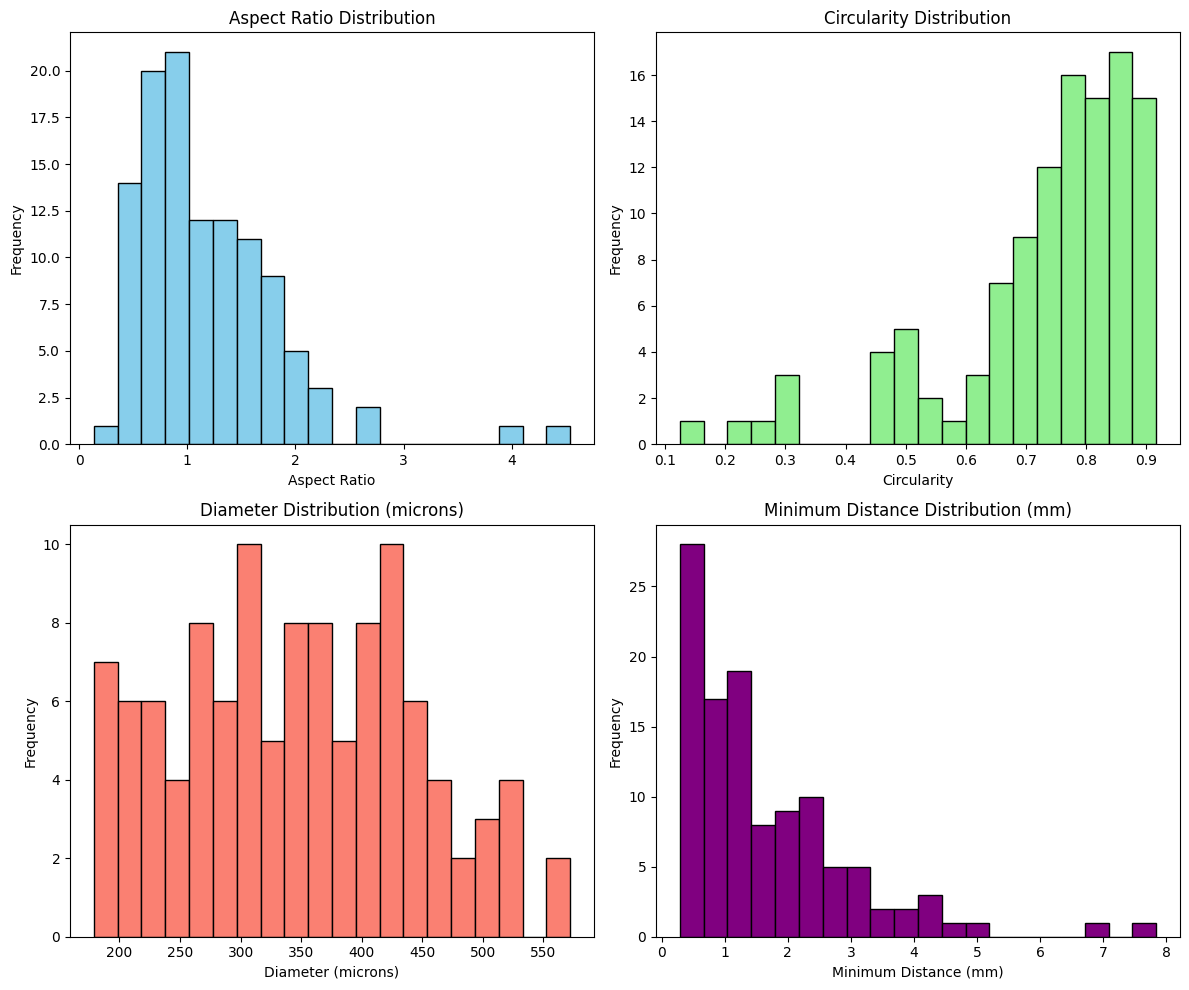

In [60]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram of aspect ratio
axes[0, 0].hist(fsm.cr.cuboid_df['aspect_ratio'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Aspect Ratio Distribution')
axes[0, 0].set_xlabel('Aspect Ratio')
axes[0, 0].set_ylabel('Frequency')

# Plot histogram of circularity
axes[0, 1].hist(fsm.cr.cuboid_df['circularity'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Circularity Distribution')
axes[0, 1].set_xlabel('Circularity')
axes[0, 1].set_ylabel('Frequency')

# Plot histogram of diameter in microns
axes[1, 0].hist(fsm.cr.cuboid_df['diameter_microns'], bins=20, color='salmon', edgecolor='black')
axes[1, 0].set_title('Diameter Distribution (microns)')
axes[1, 0].set_xlabel('Diameter (microns)')
axes[1, 0].set_ylabel('Frequency')

# Plot histogram of minimum distance in mm
axes[1, 1].hist(fsm.cr.cuboid_df['min_dist_mm'], bins=20, color='purple', edgecolor='black')
axes[1, 1].set_title('Minimum Distance Distribution (mm)')
axes[1, 1].set_xlabel('Minimum Distance (mm)')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

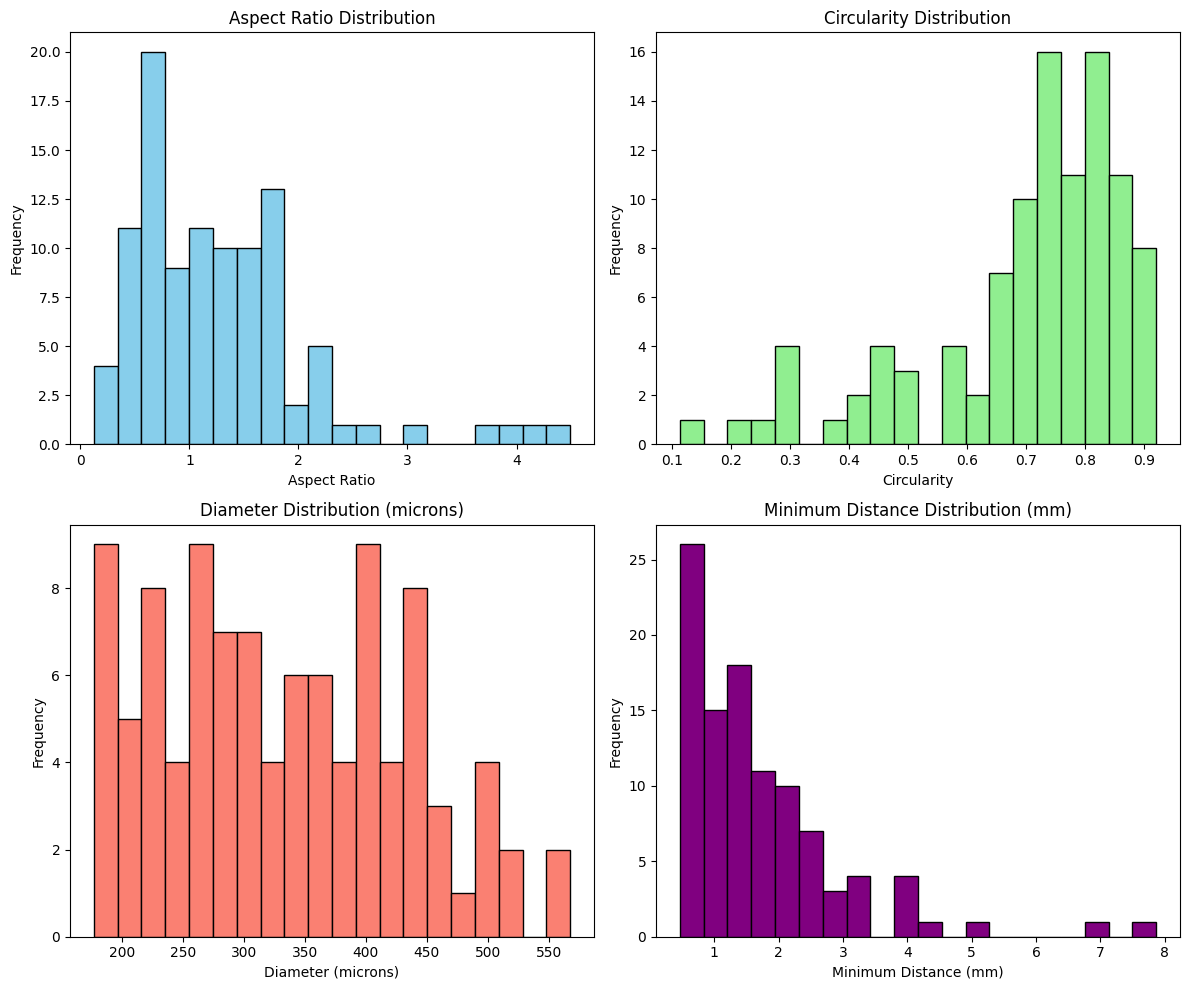

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram of aspect ratio
axes[0, 0].hist(df_diff['aspect_ratio'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Aspect Ratio Distribution')
axes[0, 0].set_xlabel('Aspect Ratio')
axes[0, 0].set_ylabel('Frequency')

# Plot histogram of circularity
axes[0, 1].hist(df_diff['circularity'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Circularity Distribution')
axes[0, 1].set_xlabel('Circularity')
axes[0, 1].set_ylabel('Frequency')

# Plot histogram of diameter in microns
axes[1, 0].hist(df_diff['diameter_microns'], bins=20, color='salmon', edgecolor='black')
axes[1, 0].set_title('Diameter Distribution (microns)')
axes[1, 0].set_xlabel('Diameter (microns)')
axes[1, 0].set_ylabel('Frequency')

# Plot histogram of minimum distance in mm
axes[1, 1].hist(df_diff['min_dist_mm'], bins=20, color='purple', edgecolor='black')
axes[1, 1].set_title('Minimum Distance Distribution (mm)')
axes[1, 1].set_xlabel('Minimum Distance (mm)')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

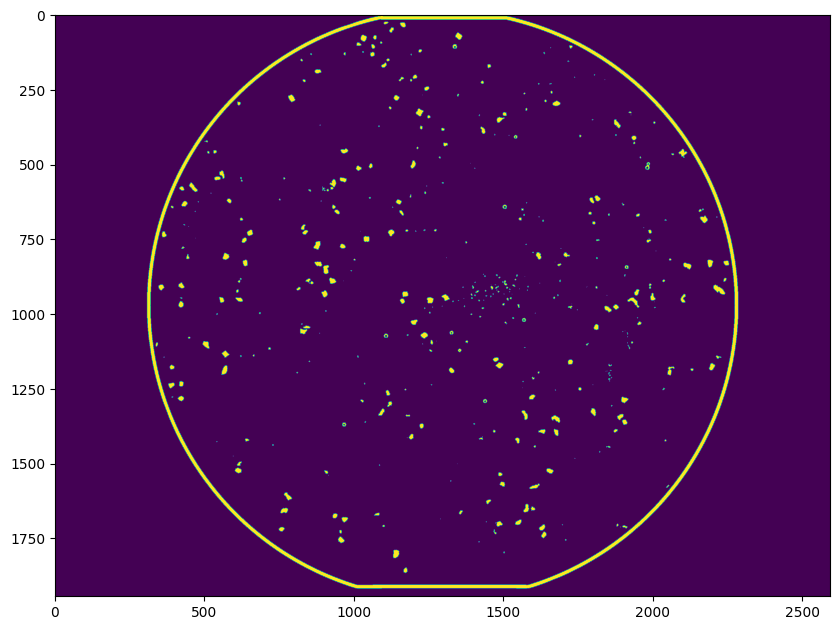

In [169]:
plt.figure(figsize=(10, 10))
plt.imshow(fsm.bubble_thresh)

# Cuboid recognition

In [ ]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])


# window = cap.get_window()

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    # if event == cv2.EVENT_LBUTTONDBLCLK:
    #     for contour in filtered_contours:
    #         r=cv2.pointPolygonTest(contour, (x,y), False)
    #         if r>0:
    #             M = cv2.moments(contour)
    #             if M["m00"] != 0:
    #                 cX = int(M["m10"] / M["m00"])
    #                 cY = int(M["m01"] / M["m00"])
    #                 X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

    #                 x, y, _ = openapi.get_position(verbose=False)[0].values()
    #                 diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
    #                 X = X_init + diff[0] + offset[0]
    #                 Y = Y_init + diff[1] + offset[1]
                    
    #                 print(f"Robot coords: ({x}, {y})")
    #                 print(f"Clicked on: ({X}, {Y})")
    #                 openapi.move_to_coordinates((X, Y, 15), min_z_height=1, verbose=False)
    #                 # openapi.aspirate_in_place(flow_rate = 75, volume = 10)

                    
    #             else:
    #                 print("Contour center could not be found")

    # if event == cv2.EVENT_RBUTTONDOWN:
    #     x, y, _ = openapi.get_position(verbose=False)[0].values()
    #     # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
    #     openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

# cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 900
# manual_movement = utils.ManualRobotMovement(openapi)
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
while True:
    ret, frame = over_cam.read()
    # x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    # cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    cv2.circle(frame, circle_center, circle_radius, (255, 0, 0), 2)
    # Create a mask with the same dimensions as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)

    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, mask)

    # Convert the masked frame to grayscale
    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to the grayscale image
    # _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)

    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,41,2) 
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    # Fill the area outside the circle with black pixels
    # Convert the mask to grayscale
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)

    # frame[thresh == 255] = [0, 255, 0]

    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



    # Filter the contours to exclude the outermost
    filtered_contours = [contour for contour, h in zip(contours, hei[0]) if h[3] == 1]
    # Filter the contours by size
    filtered_contours = [contour for contour in contours if 15 < cv2.contourArea(contour) < 1000]
    # Draw the contours on the frame
    cv2.drawContours(frame, filtered_contours, -1, (0, 255, 0), 2)

    cv2.imshow("video", frame)
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

        
cv2.destroyAllWindows()

In [ ]:
openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(1,-1,0), verbose=False)